In [1]:
from massspecgym.data.datasets import MSnDataset, MassSpecDataset
from massspecgym.data.transforms import MolFingerprinter, SpecTokenizer
from massspecgym.data import MassSpecDataModule
from massspecgym.featurize import SpectrumFeaturizer

from collections import defaultdict
from itertools import combinations
from typing import List
from scipy import stats
from math import comb
import numpy as np

import pandas as pd
from typing import List, Dict, Tuple, Optional, Any

In [2]:
file_mgf = "/Users/macbook/CODE/Majer:MassSpecGym/data/MSn/20241211_msn_library_pos_all_lib_MSn.mgf"
split_file = "/Users/macbook/CODE/Majer:MassSpecGym/data/MSn/20241211_split.tsv"

In [3]:
config = {
    'features': ['binned_peaks'],
    'feature_attributes': {
        'binned_peaks': {
            'max_mz': 1005,
            'bin_width': 1.0,
        },
    },
}

In [4]:
featurizer = SpectrumFeaturizer(config, mode='torch')

In [5]:
# Init hyperparameters
n_peaks = 60
fp_size = 4096
batch_size = 12

msn_dataset = MSnDataset(
    pth=file_mgf,
    featurizer=featurizer,
    mol_transform=MolFingerprinter(fp_size=fp_size),
    max_allowed_deviation=0.005
)

In [6]:
msn_dataset[0]

{'spec': Data(x=[14, 1005], edge_index=[2, 13]),
 'mol': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 'precursor_mz': tensor(347.1489),
 'adduct': '[M+H]+',
 'identifier': '0000002_0000000',
 'mol_freq': tensor(1.)}

## Spectra node similarities

In [7]:
def summarize_similarity_distribution_aggregated(scores: List[float]) -> dict:
    """
    Return mean, std, median, count for a list of float scores,
    ignoring NaNs.
    """
    arr = np.array(scores)
    arr = arr[~np.isnan(arr)]
    if len(arr) == 0:
        return {"mean": np.nan, "std": np.nan, "median": np.nan, "count": 0}
    return {
        "mean": float(np.mean(arr)),
        "std": float(np.std(arr)),
        "median": float(np.median(arr)),
        "count": len(arr)
    }

In [8]:
def summarize_similarity_distribution(scores: List[float], normality_alpha: float = 0.05) -> Dict[str, Any]:
    """
    Summarize similarity scores with extended statistics and normality tests.
    
    Parameters:
    - scores: List of similarity scores (floats)
    - normality_alpha: Significance level for normality tests
    
    Returns:
    - Dictionary with comprehensive statistics
    """
    arr = np.array(scores)
    arr = arr[~np.isnan(arr)]
    summary = {}
    
    if len(arr) == 0:
        summary = {
            "mean": np.nan,
            "std": np.nan,
            "median": np.nan,
            "count": 0,
            # "mode": np.nan,
            "q1": np.nan,
            "q3": np.nan,
            "IQR": np.nan,
            "range": np.nan,
            "skewness": np.nan,
            "kurtosis": np.nan,
            "ks_p": np.nan,
            "is_normal": False
        }
        return summary
    
    summary["mean"] = float(np.mean(arr))
    summary["std"] = float(np.std(arr))
    summary["median"] = float(np.median(arr))
    summary["count"] = len(arr)
    # summary["mode"] = float(stats.mode(arr).mode[0])
    summary["q1"] = float(np.percentile(arr, 25))
    summary["q3"] = float(np.percentile(arr, 75))
    summary["IQR"] = summary["q3"] - summary["q1"]
    summary["range"] = float(np.ptp(arr))
    summary["skewness"] = float(stats.skew(arr))
    summary["kurtosis"] = float(stats.kurtosis(arr))
    
    # Kolmogorov-Smirnov Test against normal distribution
    ks_stat, ks_p = stats.kstest(arr, 'norm', args=(summary["mean"], summary["std"]))
    
    summary["ks_p"] = ks_p
    
    # Determine normality based on KS test
    if ks_p >= normality_alpha:
        is_normal = True
    else:
        is_normal = False
    
    summary["is_normal"] = is_normal
    
    return summary

In [9]:
# def perform_statistical_tests(all_level_sims: Dict[Tuple[int, int], List[float]], alpha: float = 0.05) -> List[Dict[str, Any]]:
#     """
#     Perform statistical tests between all level pairs.
#     
#     Parameters:
#     - all_level_sims: Dict mapping level pairs to list of similarity scores
#     - alpha: Significance level
#     
#     Returns:
#     - List of dictionaries containing comparison results
#     """
#     # Summarize distributions and assess normality
#     summaries = {level_pair: summarize_similarity_distribution(vals) 
#                 for level_pair, vals in all_level_sims.items()}
#     
#     # Prepare for pairwise comparisons
#     level_pairs = list(all_level_sims.keys())
#     comparison_results = []
#     
#     # Total number of comparisons for Bonferroni
#     m = comb(len(level_pairs), 2) if len(level_pairs) > 1 else 0
#     if m > 0:
#         adjusted_alpha = alpha / m
#     else:
#         adjusted_alpha = alpha
#     
#     # Perform pairwise comparisons
#     for (lvlA1, lvlB1), (lvlA2, lvlB2) in combinations(level_pairs, 2):
#         # Define comparison labels
#         group1_label = f"{lvlA1}-{lvlB1}"
#         group2_label = f"{lvlA2}-{lvlB2}"
#         
#         scores1 = all_level_sims[(lvlA1, lvlB1)]
#         scores2 = all_level_sims[(lvlA2, lvlB2)]
#         
#         summary1 = summaries[(lvlA1, lvlB1)]
#         summary2 = summaries[(lvlA2, lvlB2)]
#         
#         # Decide which test to use based on normality
#         if summary1["is_normal"] and summary2["is_normal"]:
#             # Perform Welch's t-test
#             t_stat, p_val = stats.ttest_ind(scores1, scores2, equal_var=False, nan_policy='omit')
#             test_used = "Welch's t-test"
#         else:
#             # Perform Mann-Whitney U test
#             t_stat, p_val = stats.mannwhitneyu(scores1, scores2, alternative='two-sided')
#             test_used = "Mann-Whitney U test"
#         
#         # Determine significance with Bonferroni correction
#         significant = p_val < adjusted_alpha
#         
#         comparison_results.append({
#             "Group 1": group1_label,
#             "Group 2": group2_label,
#             "Test Used": test_used,
#             "Statistic": t_stat,
#             "p-value": p_val,
#             "Significant": significant,
#             "Adjusted Alpha": adjusted_alpha
#         })
#     
#     return comparison_results

In [10]:

def report_comparison_results(comparison_results: List[Dict[str, Any]]):
    """
    Print comparison results in a structured format.
    
    Parameters:
    - comparison_results: List of dictionaries containing comparison details
    """
    if not comparison_results:
        print("No comparisons to report.")
        return
    
    df = pd.DataFrame(comparison_results)
    
    # Rearrange columns for clarity
    df = df[[
        "Group 1", 
        "Group 2", 
        "Test Used", 
        "Statistic", 
        "p-value", 
        "Adjusted Alpha", 
        "Significant"
    ]]
    
    # Sort by p-value
    df = df.sort_values(by="p-value")
    
    # Display the DataFrame
    print(df.to_string(index=False))

In [11]:
def perform_statistical_tests_with_effect_sizes(all_level_sims: Dict[Tuple[int, int], List[float]], alpha: float = 0.05) -> List[Dict[str, Any]]:
    """
    Perform statistical tests between all level pairs and calculate effect sizes.
    
    Parameters:
    - all_level_sims: Dict mapping level pairs to list of similarity scores
    - alpha: Significance level
    
    Returns:
    - List of dictionaries containing comparison results including effect sizes
    """
    # Summarize distributions and assess normality
    summaries = {level_pair: summarize_similarity_distribution(vals) 
                for level_pair, vals in all_level_sims.items()}
    
    # Prepare for pairwise comparisons
    level_pairs = list(all_level_sims.keys())
    comparison_results = []
    
    # Total number of comparisons for Bonferroni
    m = comb(len(level_pairs), 2) if len(level_pairs) > 1 else 0
    if m > 0:
        adjusted_alpha = alpha / m
    else:
        adjusted_alpha = alpha
    
    # Perform pairwise comparisons
    for (lvlA1, lvlB1), (lvlA2, lvlB2) in combinations(level_pairs, 2):
        # Define comparison labels
        group1_label = f"{lvlA1}-{lvlB1}"
        group2_label = f"{lvlA2}-{lvlB2}"
        
        scores1 = all_level_sims[(lvlA1, lvlB1)]
        scores2 = all_level_sims[(lvlA2, lvlB2)]
        
        summary1 = summaries[(lvlA1, lvlB1)]
        summary2 = summaries[(lvlA2, lvlB2)]
        
        # Decide which test to use based on normality
        if summary1["is_normal"] and summary2["is_normal"]:
            # Perform Welch's t-test
            t_stat, p_val = stats.ttest_ind(scores1, scores2, equal_var=False, nan_policy='omit')
            test_used = "Welch's t-test"
            # Calculate Cohen's d
            mean_diff = summary1["mean"] - summary2["mean"]
            pooled_var = ((summary1["std"]**2) / summary1["count"] + (summary2["std"]**2) / summary2["count"])
            pooled_std = np.sqrt(pooled_var)
            cohen_d = mean_diff / pooled_std
            effect_size = cohen_d
            effect_size_label = "Cohen's d"
        else:
            # Perform Mann-Whitney U test
            u_stat, p_val = stats.mannwhitneyu(scores1, scores2, alternative='two-sided')
            test_used = "Mann-Whitney U test"
            # Calculate Rank-Biserial Correlation as effect size
            n1 = len(scores1)
            n2 = len(scores2)
            rbc = 1 - (2 * u_stat) / (n1 * n2)
            effect_size = rbc
            effect_size_label = "Rank-Biserial Correlation"
        
        # Determine significance with Bonferroni correction
        significant = p_val < adjusted_alpha
        
        comparison_results.append({
            "Group 1": group1_label,
            "Group 2": group2_label,
            "Test Used": test_used,
            "Statistic": t_stat if test_used == "Welch's t-test" else u_stat,
            "p-value": p_val,
            "Adjusted Alpha": adjusted_alpha,
            "Significant": significant,
            "Effect Size": effect_size,
            "Effect Size Type": effect_size_label
        })
    
    return comparison_results

def report_comparison_results_with_effect_sizes(comparison_results: List[Dict[str, Any]]):
    """
    Print comparison results with effect sizes in a structured format.
    
    Parameters:
    - comparison_results: List of dictionaries containing comparison details
    """
    if not comparison_results:
        print("No comparisons to report.")
        return
    
    df = pd.DataFrame(comparison_results)
    
    # Rearrange columns for clarity
    df = df[[
        "Group 1", 
        "Group 2", 
        "Test Used", 
        "Statistic", 
        "p-value", 
        "Adjusted Alpha",
        "Significant",
        "Effect Size",
        "Effect Size Type"
    ]]
    
    # Sort by p-value
    df = df.sort_values(by="p-value")
    
    # Display the DataFrame
    print(df.to_string(index=False))

In [12]:
def compare_target_group_against_others(
    all_level_sims: Dict[Tuple[int, int], List[float]],
    target_level_pair: Tuple[int, int],
    alpha: float = 0.05
) -> pd.DataFrame:
    """
    Compare the target level pair's similarity scores against all other level pairs.
    
    Parameters:
    - all_level_sims: Dict mapping level pairs to list of similarity scores
    - target_level_pair: Tuple indicating the target level pair (e.g., (2,2))
    - alpha: Significance level
    
    Returns:
    - Pandas DataFrame with comparison results
    """
    target_scores = all_level_sims.get(target_level_pair, [])
    if not target_scores:
        raise ValueError(f"No similarity scores found for target level pair {target_level_pair}")
    
    # Summarize the target group
    summary_target = summarize_similarity_distribution(target_scores)
    
    comparison_results = []
    
    # Number of comparisons for Bonferroni correction
    other_level_pairs = [lp for lp in all_level_sims.keys() if lp != target_level_pair]
    m = len(other_level_pairs)
    if m == 0:
        raise ValueError("No other level pairs to compare against.")
    adjusted_alpha = alpha / m  # Bonferroni correction
    
    # Iterate over all other level pairs
    for level_pair in other_level_pairs:
        other_scores = all_level_sims[level_pair]
        summary_other = summarize_similarity_distribution(other_scores)
        
        # Decide which test to use based on normality
        if summary_target["is_normal"] and summary_other["is_normal"]:
            # Perform Welch's t-test
            t_stat, p_val = stats.ttest_ind(target_scores, other_scores, equal_var=False, nan_policy='omit')
            test_used = "Welch's t-test"
            # Calculate Cohen's d
            mean_diff = summary_target["mean"] - summary_other["mean"]
            pooled_var = ((summary_target["std"]**2) / summary_target["count"] + 
                         (summary_other["std"]**2) / summary_other["count"])
            pooled_std = np.sqrt(pooled_var)
            cohen_d = mean_diff / pooled_std
            effect_size = cohen_d
            effect_size_label = "Cohen's d"
        else:
            # Perform Mann-Whitney U test
            try:
                u_stat, p_val = stats.mannwhitneyu(target_scores, other_scores, alternative='two-sided')
            except ValueError as e:
                # Handle cases where all values are identical
                u_stat, p_val = np.nan, np.nan
            test_used = "Mann-Whitney U test"
            # Calculate Rank-Biserial Correlation as effect size
            if not np.isnan(u_stat):
                n1 = len(target_scores)
                n2 = len(other_scores)
                rbc = 1 - (2 * u_stat) / (n1 * n2)
            else:
                rbc = np.nan
            effect_size = rbc
            effect_size_label = "Rank-Biserial Correlation"
        
        # Determine significance with Bonferroni correction
        significant = p_val < adjusted_alpha if not np.isnan(p_val) else False
        
        comparison_results.append({
            "Target Group": f"{target_level_pair}",
            "Compared Group": f"{level_pair}",
            "Test Used": test_used,
            "Statistic": t_stat if test_used == "Welch's t-test" else u_stat,
            "p-value": p_val,
            "Adjusted Alpha": adjusted_alpha,
            "Significant": significant,
            "Effect Size": effect_size,
            "Effect Size Type": effect_size_label
        })
    
    # Convert to DataFrame for better readability
    df_results = pd.DataFrame(comparison_results)
    
    # Sort by p-value
    df_results = df_results.sort_values(by="p-value")
    
    return df_results

In [13]:
def convert_similarity_scores(similarity_scores):
    """
    Convert a list of numpy.ndarray similarity scores to a list of floats.
    
    Parameters:
    - similarity_scores: List of numpy.ndarray objects containing single floats
    
    Returns:
    - List of floats
    """
    return [float(score) for score in similarity_scores]

## Comparing results

In [14]:
from massspecgym.tools.data import (compute_cosine_hungarian_score, compute_pairwise_similarity_by_mslevel, compute_same_level_similarity_limited,compute_ancestor_descendant_similarity, compute_sibling_similarity, random_node_pairs)

from massspecgym.tools.plots import plot_histograms, plot_histograms_by_level_pairs
from massspecgym.tools.io import load_embeddings


In [15]:
# Your existing analysis code
# For normal similarity function (hungarian_fn)
def hungarian_fn(specA, specB):
    (sc, _) = compute_cosine_hungarian_score(specA, specB, tolerance=0.1)
    return (sc, 0)


In [16]:
# MS-Level Pair Analysis (hungarian_fn based)
all_level_sims_hung = defaultdict(list)

for tree in msn_dataset.trees:
    level_sims_dict = compute_pairwise_similarity_by_mslevel(
        tree, use_embedding=False, sim_fn=hungarian_fn
    )
    for (lvlA, lvlB), simvals in level_sims_dict.items():
        all_level_sims_hung[(lvlA, lvlB)].extend(simvals)

In [17]:
# # Print average for each level pair
# for level_pair, vals in all_level_sims_hung.items():
#     stats_lv = summarize_similarity_distribution(vals)
#     print(f"Level pair {level_pair} -> {stats_lv}")

In [18]:
# # Summarize and perform statistical tests for hungarian_fn similarities
# print("\n--- Statistical Analysis for Hungarian Similarity Function ---")
# comparison_results_hung = perform_statistical_tests_with_effect_sizes(all_level_sims_hung, alpha=0.05)
# report_comparison_results_with_effect_sizes(comparison_results_hung)

In [19]:
# Limited MS2<->MS2 similarities (hungarian_fn)
ms2_sims_hung = compute_same_level_similarity_limited(
    msn_dataset,
    target_level=2,
    use_embedding=False,
    sim_fn=hungarian_fn,
    tolerance=0.1,
    max_pairs=500
)

In [20]:
# stats_ms2_hung = summarize_similarity_distribution(ms2_sims_hung)
# print("\nMS2<->MS2 (Hungarian) limited stats:", stats_ms2_hung)

In [21]:
# Initialize (2,2) if not present
if (2, 2) not in all_level_sims_hung:
    all_level_sims_hung[(2, 2)] = []

all_level_sims_hung[(2, 2)].extend(ms2_sims_hung)


In [22]:
for level_pair in all_level_sims_hung.keys():
    all_level_sims_hung[level_pair] = convert_similarity_scores(all_level_sims_hung[level_pair])

# Verify the conversion
print(f"Type of all_level_sims_hung[(2, 2)][0]: {type(all_level_sims_hung[(2, 2)][0])}")
print(f"First 5 similarity scores for (2, 2): {all_level_sims_hung[(2, 2)][:5]}")

Type of all_level_sims_hung[(2, 2)][0]: <class 'float'>
First 5 similarity scores for (2, 2): [0.0, 0.0006518641256617711, 0.0009997034206200323, 0.0, 0.01588136470150715]


In [23]:
# Print average for each level pair
for level_pair, vals in all_level_sims_hung.items():
    stats_lv = summarize_similarity_distribution(vals)
    print(f"Level pair {level_pair} -> {stats_lv}")

Level pair (2, 3) -> {'mean': 0.39291368614045286, 'std': 0.29446695517700344, 'median': 0.3235879346057741, 'count': 71933, 'q1': 0.13362602081935926, 'q3': 0.6344383589923479, 'IQR': 0.5008123381729886, 'range': 0.9995800041106572, 'skewness': 0.48872539637428364, 'kurtosis': -1.0411544580415926, 'ks_p': 0.0, 'is_normal': False}
Level pair (2, 4) -> {'mean': 0.15920017039996986, 'std': 0.2026399596469752, 'median': 0.07434368995850654, 'count': 80364, 'q1': 0.02185318192276241, 'q3': 0.2126005494627695, 'IQR': 0.19074736754000707, 'range': 0.9959788048473043, 'skewness': 1.8430302018936078, 'kurtosis': 2.9530116284363856, 'ks_p': 0.0, 'is_normal': False}
Level pair (3, 3) -> {'mean': 0.2554785019529586, 'std': 0.31310530745819204, 'median': 0.10053266364833399, 'count': 139192, 'q1': 0.010903632159481678, 'q3': 0.4247133244980841, 'IQR': 0.4138096923386024, 'range': 0.9999999998048363, 'skewness': 1.1394792752124678, 'kurtosis': -0.07039736518531114, 'ks_p': 0.0, 'is_normal': False}


In [24]:
# Summarize and perform statistical tests for hungarian_fn similarities
print("\n--- Statistical Analysis for Hungarian Similarity Function ---")
comparison_results_hung = perform_statistical_tests_with_effect_sizes(all_level_sims_hung, alpha=0.05)
report_comparison_results_with_effect_sizes(comparison_results_hung)


--- Statistical Analysis for Hungarian Similarity Function ---
Group 1 Group 2           Test Used    Statistic       p-value  Adjusted Alpha  Significant  Effect Size          Effect Size Type
    2-3     2-4 Mann-Whitney U test 4.418347e+09  0.000000e+00        0.001111         True    -0.528622 Rank-Biserial Correlation
    4-5     5-5 Mann-Whitney U test 1.104435e+09  0.000000e+00        0.001111         True     0.201598 Rank-Biserial Correlation
    3-5     5-5 Mann-Whitney U test 6.045751e+08  0.000000e+00        0.001111         True     0.303949 Rank-Biserial Correlation
    3-5     4-5 Mann-Whitney U test 3.736132e+09  0.000000e+00        0.001111         True     0.112870 Rank-Biserial Correlation
    2-5     5-5 Mann-Whitney U test 9.509983e+07  0.000000e+00        0.001111         True     0.451280 Rank-Biserial Correlation
    2-5     4-5 Mann-Whitney U test 5.945492e+08  0.000000e+00        0.001111         True     0.292489 Rank-Biserial Correlation
    2-5     3-5 Man

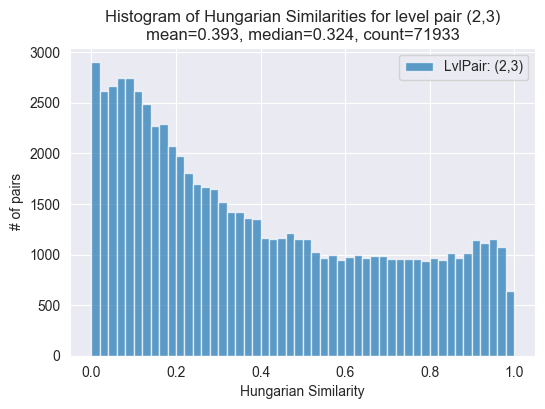

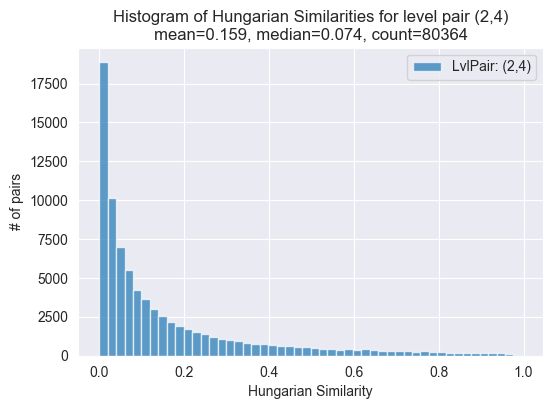

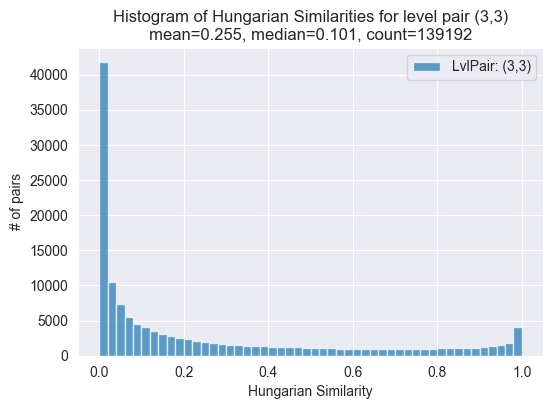

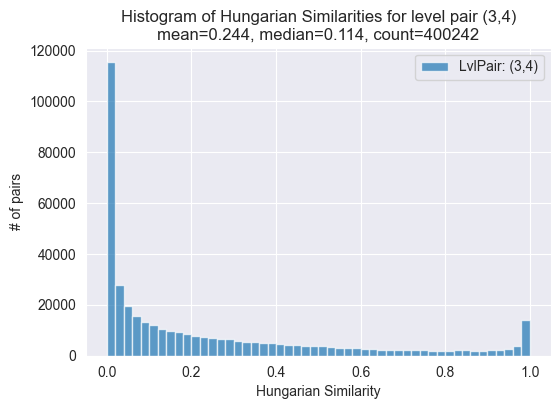

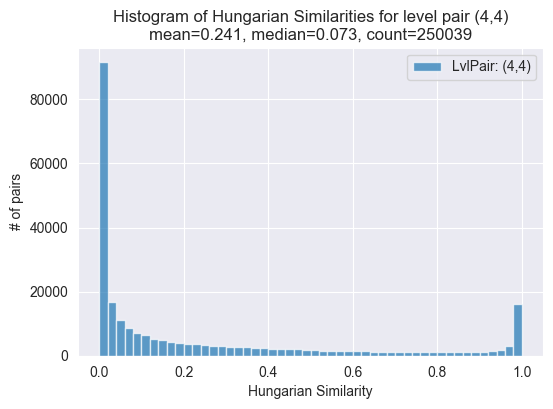

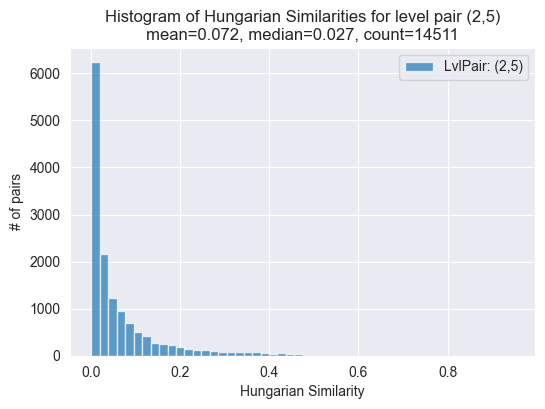

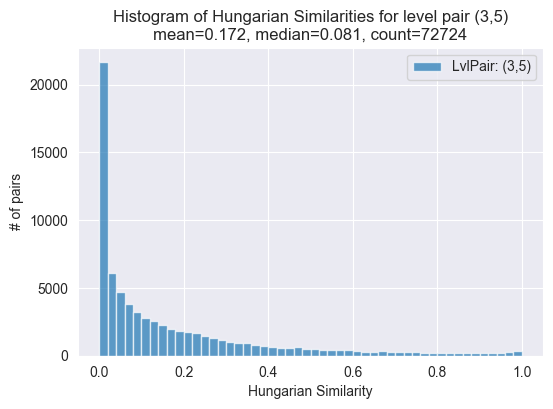

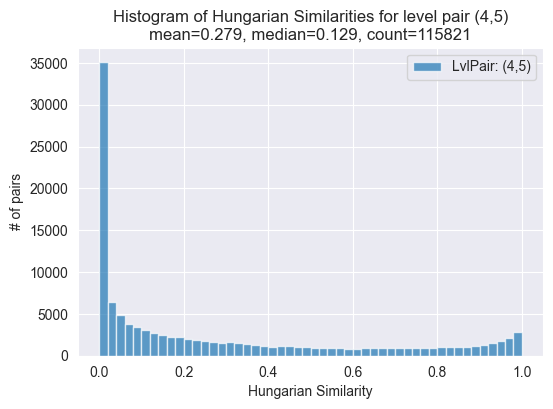

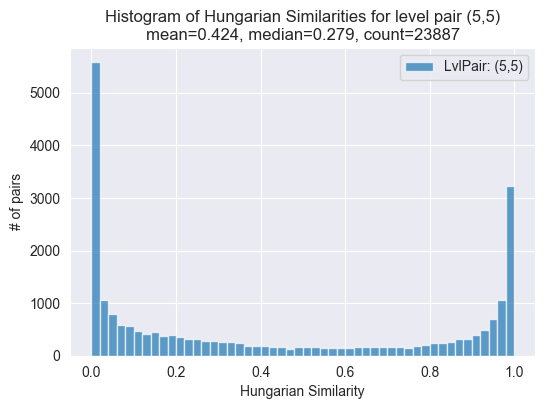

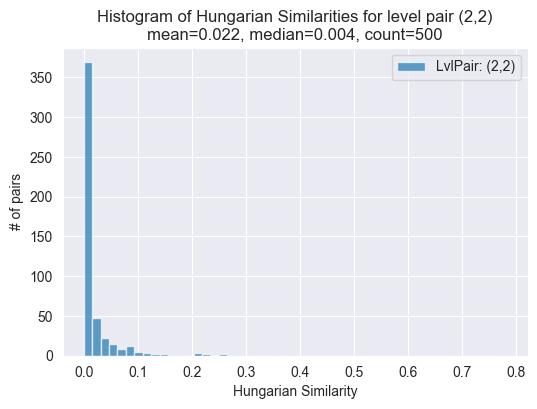

In [25]:
# Optionally plot each level pair in a separate figure:
plot_histograms_by_level_pairs(all_level_sims_hung, mode="Hungarian")

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
def plot_histogram_kde(all_level_sims: Dict[Tuple[int, int], List[float]], target_level_pair: Tuple[int, int], title: str):
    """
    Plot histogram with KDE overlay for a specific level pair.
    
    Parameters:
    - all_level_sims: Dict mapping level pairs to list of similarity scores
    - target_level_pair: Tuple indicating the target level pair (e.g., (2,2))
    - title: Title of the plot
    """
    sims = all_level_sims.get(target_level_pair, [])
    
    # Diagnostic Prints
    print(f"Type of sims: {type(sims)}")
    print(f"Length of sims: {len(sims)}")
    if isinstance(sims, list):
        if len(sims) > 0:
            print(f"First 5 elements: {sims[:5]}")
        else:
            print("sims list is empty.")
    else:
        print("sims is not a list.")
    
    if not sims:
        print(f"No similarity scores found for level pair {target_level_pair}.")
        return
    
    # Ensure all elements are numeric
    sims_numeric = [score for score in sims if isinstance(score, (int, float, np.integer, np.floating))]
    non_numeric = len(sims) - len(sims_numeric)
    if non_numeric > 0:
        print(f"Removed {non_numeric} non-numeric similarity scores.")

    if not sims_numeric:
        print(f"No numeric similarity scores available for level pair {target_level_pair}.")
        return
    
    plt.figure(figsize=(10, 6))
    sns.histplot(sims_numeric, bins=50, kde=True, stat="density", color='skyblue', edgecolor='black')
    plt.title(f"{title} for Level Pair {target_level_pair}")
    plt.xlabel("Similarity Score")
    plt.ylabel("Density")
    plt.xlim(-0.1, 1.1)  # Adjust based on similarity score range
    plt.show()

def plot_boxplots(all_level_sims: Dict[Tuple[int, int], List[float]], title: str):
    """
    Plot boxplots of similarity scores for multiple level pairs.
    
    Parameters:
    - all_level_sims: Dict mapping level pairs to list of similarity scores
    - title: Title of the plot
    """
    data = []
    for (lvlA, lvlB), sims in all_level_sims.items():
        label = f"{lvlA}-{lvlB}"
        for sim in sims:
            data.append({"Level Pair": label, "Similarity": sim})
    
    df = pd.DataFrame(data)
    
    plt.figure(figsize=(14, 8))
    sns.boxplot(x="Level Pair", y="Similarity", data=df, palette="Set3")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.xlabel("MS Level Pair")
    plt.ylabel("Similarity Score")
    plt.show()

In [28]:
def plot_density(all_level_sims: Dict[Tuple[int, int], List[float]], title: str):
    """
    Plot density plots of similarity scores for all level pairs.
    
    Parameters:
    - all_level_sims: Dict mapping level pairs to list of similarity scores
    - title: Title of the plot
    """
    plt.figure(figsize=(14, 8))
    for (lvlA, lvlB), sims in all_level_sims.items():
        label = f"{lvlA}-{lvlB}"
        sns.kdeplot(sims, label=label, shade=False)
    
    plt.title(title)
    plt.xlabel("Similarity Score")
    plt.ylabel("Density")
    plt.legend(title="MS Level Pairs", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()
    
def plot_comparative_histogram(all_level_sims: Dict[Tuple[int, int], List[float]], target_level_pair: Tuple[int, int], compare_level_pair: Tuple[int, int], title: str):
    """
    Plot comparative histograms for two specific level pairs.
    
    Parameters:
    - all_level_sims: Dict mapping level pairs to list of similarity scores
    - target_level_pair: Tuple indicating the target level pair (e.g., (2,2))
    - compare_level_pair: Tuple indicating the comparison level pair (e.g., (2,3))
    - title: Title of the plot
    """
    sims_target = all_level_sims.get(target_level_pair, [])
    sims_compare = all_level_sims.get(compare_level_pair, [])
    
    if not sims_target or not sims_compare:
        print(f"Insufficient data for comparison between {target_level_pair} and {compare_level_pair}.")
        return
    
    plt.figure(figsize=(10, 6))
    sns.histplot(sims_target, bins=50, kde=True, stat="density", label=f"{target_level_pair}", color='blue', alpha=0.5)
    sns.histplot(sims_compare, bins=50, kde=True, stat="density", label=f"{compare_level_pair}", color='orange', alpha=0.5)
    plt.title(title)
    plt.xlabel("Similarity Score")
    plt.ylabel("Density")
    plt.legend(title="MS Level Pairs")
    plt.xlim(-0.1, 1.1)
    plt.show()


Type of sims: <class 'list'>
Length of sims: 71933
First 5 elements: [0.09482385185445195, 0.8912841082529714, 0.005303157202610283, 0.18932301495035853, 0.898550915493607]


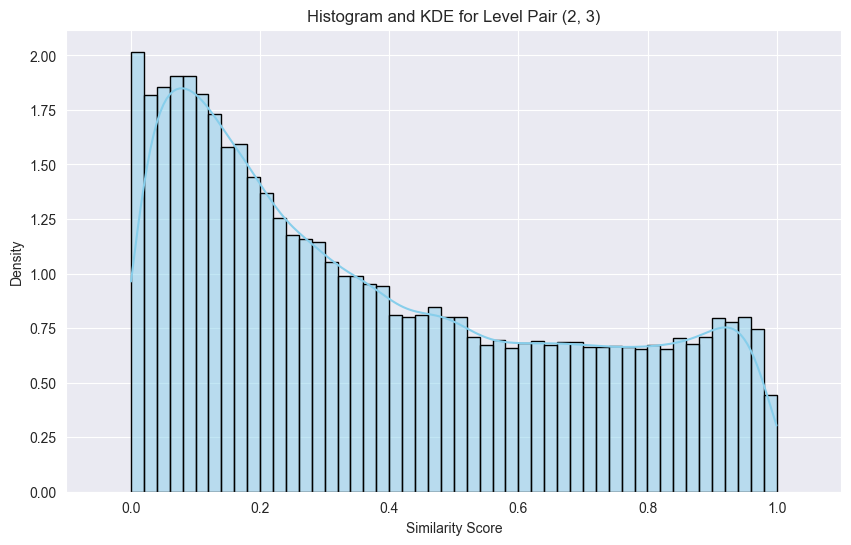

In [29]:
plot_histogram_kde(all_level_sims_hung, (2, 3), "Histogram and KDE")

/var/folders/bl/73ckjztx5js4cc0cj85qgvlm0000gn/T/ipykernel_22147/3836655273.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Level Pair", y="Similarity", data=df, palette="Set3")


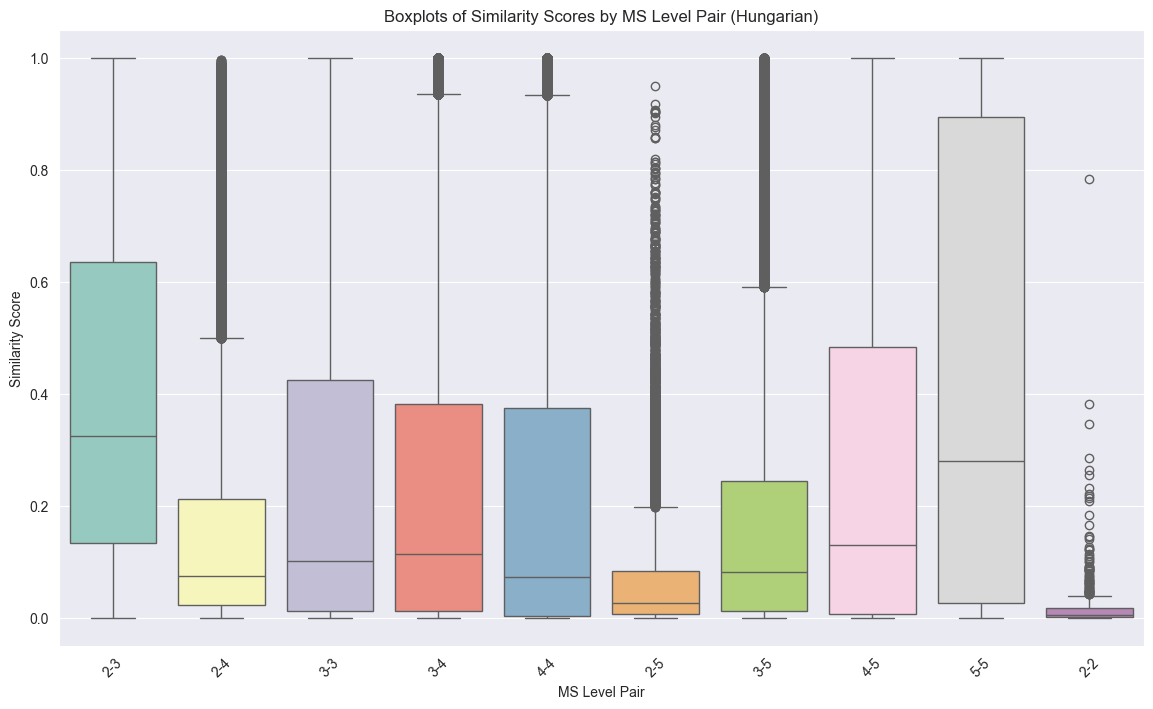

In [30]:
plot_boxplots(all_level_sims_hung, "Boxplots of Similarity Scores by MS Level Pair (Hungarian)")

/var/folders/bl/73ckjztx5js4cc0cj85qgvlm0000gn/T/ipykernel_22147/792835851.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(sims, label=label, shade=False)
/var/folders/bl/73ckjztx5js4cc0cj85qgvlm0000gn/T/ipykernel_22147/792835851.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(sims, label=label, shade=False)
/var/folders/bl/73ckjztx5js4cc0cj85qgvlm0000gn/T/ipykernel_22147/792835851.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(sims, label=label, shade=False)
/var/folders/bl/73ckjztx5js4cc0cj85qgvlm0000gn/T/ipykernel_22147/792835851.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; 

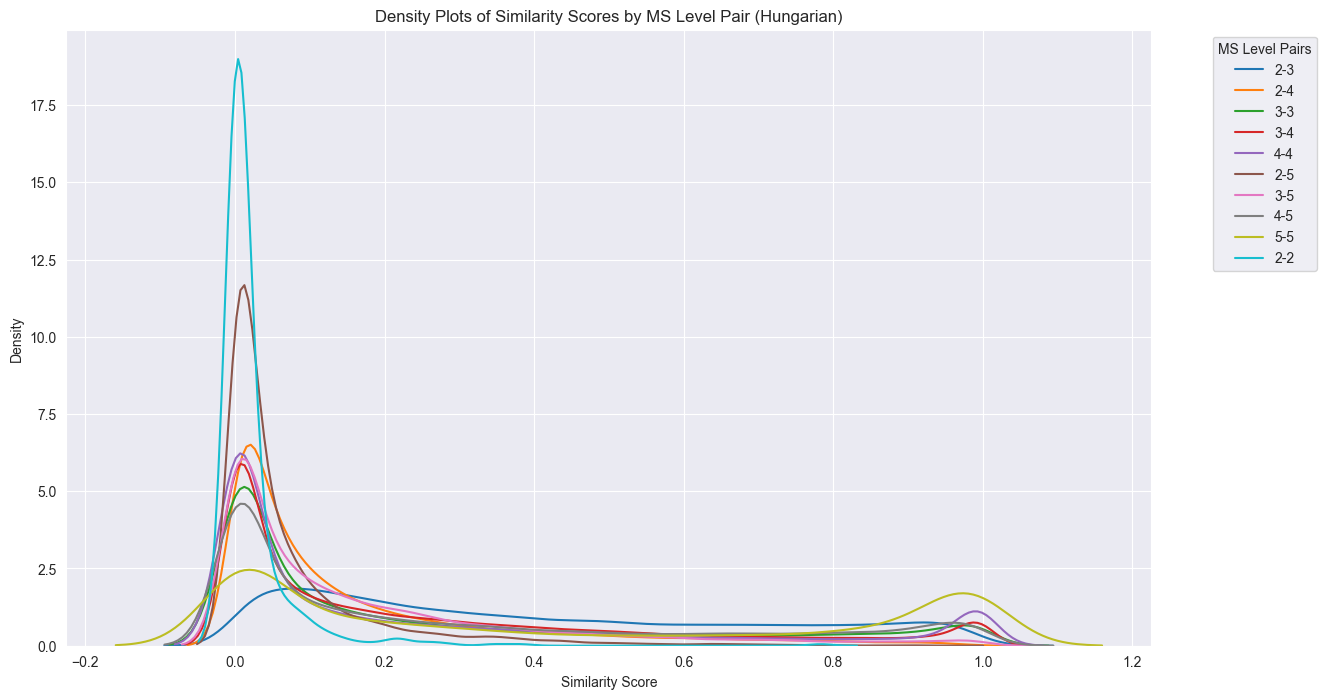

In [31]:
plot_density(all_level_sims_hung, "Density Plots of Similarity Scores by MS Level Pair (Hungarian)")

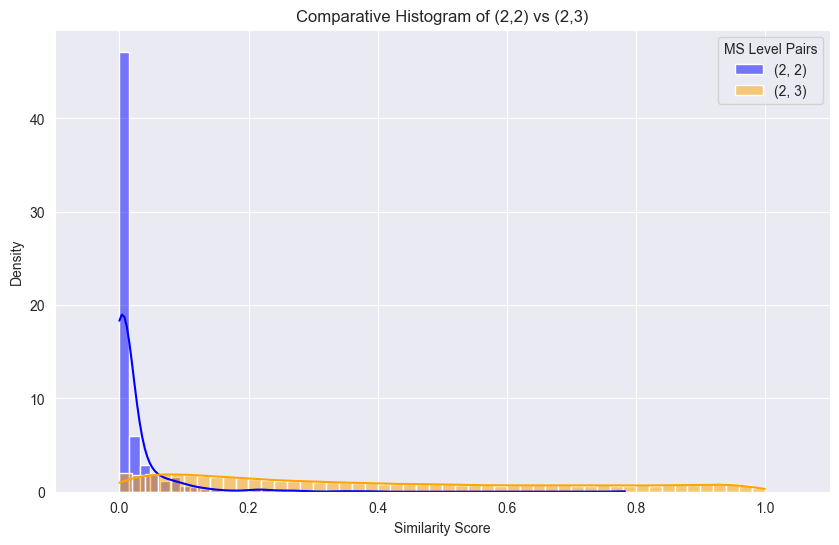

In [32]:
plot_comparative_histogram(all_level_sims_hung, (2, 2), (2, 3), "Comparative Histogram of (2,2) vs (2,3)")

## Identify best distribution for our data

In [74]:
from scipy import stats
import numpy as np
import pandas as pd
import warnings

def fit_distributions(data: List[float], distributions: List[str] = None) -> pd.DataFrame:
    """
    Fit multiple distributions to the data and evaluate goodness-of-fit using KS statistic.
    
    Parameters:
    - data: List of similarity scores (floats)
    - distributions: List of distribution names to fit. If None, a default list is used.
    
    Returns:
    - DataFrame with distribution parameters and KS statistics
    """
    if distributions is None:
        distributions = [
            'norm', 'expon', 'beta', 'gamma', 'lognorm', 'uniform', 'weibull_min',
            'weibull_max', 'pareto', 't', 'cauchy'
        ]
    
    results = []
    data = np.array(data)
    
    # Remove NaN values
    data = data[~np.isnan(data)]
    
    for dist_name in distributions:
        dist = getattr(stats, dist_name)
        try:
            # Fit distribution to data
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                params = dist.fit(data)
            
            # Perform KS test
            ks_stat, ks_p = stats.kstest(data, dist_name, args=params)
            
            # Append results
            results.append({
                'Distribution': dist_name,
                'Parameters': params,
                'KS Statistic': ks_stat,
                'KS p-value': ks_p
            })
        except Exception as e:
            print(f"Could not fit distribution {dist_name}: {e}")
            continue
    
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by='KS Statistic')
    return results_df

def fit_distributions_with_aic(data: List[float], distributions: List[str] = None) -> pd.DataFrame:
    """
    Fit multiple distributions to the data and evaluate goodness-of-fit using AIC.
    
    Parameters:
    - data: List of similarity scores (floats)
    - distributions: List of distribution names to fit. If None, a default list is used.
    
    Returns:
    - DataFrame with distribution parameters and AIC scores
    """
    if distributions is None:
        distributions = [
            'norm', 'expon', 'beta', 'gamma', 'lognorm', 'uniform', 'weibull_min',
            'weibull_max', 'pareto', 't', 'cauchy'
        ]
    
    results = []
    data = np.array(data)
    
    # Remove NaN values
    data = data[~np.isnan(data)]
    
    for dist_name in distributions:
        dist = getattr(stats, dist_name)
        try:
            # Fit distribution to data
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                params = dist.fit(data)
            
            # Calculate log-likelihood
            log_likelihood = np.sum(dist.logpdf(data, *params))
            
            # Number of parameters
            k = len(params)
            
            # Calculate AIC
            aic = 2*k - 2*log_likelihood
            
            # Append results
            results.append({
                'Distribution': dist_name,
                'Parameters': params,
                'AIC': aic
            })
        except Exception as e:
            print(f"Could not fit distribution {dist_name}: {e}")
            continue
    
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by='AIC')
    return results_df

def identify_top_fits(df: pd.DataFrame, criterion: str = 'KS Statistic', top_n: int = 5) -> pd.DataFrame:
    """
    Identify the top N best-fitting distributions based on a specified criterion.
    
    Parameters:
    - df: DataFrame containing distribution fit results
    - criterion: Column name to sort by ('KS Statistic' or 'AIC')
    - top_n: Number of top distributions to return
    
    Returns:
    - DataFrame of top N distributions
    """
    if criterion not in df.columns:
        raise ValueError(f"Criterion '{criterion}' not found in DataFrame columns.")
    
    top_fits = df.nsmallest(top_n, criterion)
    return top_fits

def summarize_all_level_pairs(
    all_level_sims: Dict[Tuple[int, int], List[float]],
    top_n: int = 5
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Fit distributions to all level pairs and summarize the top N best-fitting distributions based on KS and AIC.
    
    Parameters:
    - all_level_sims: Dict mapping level pairs to list of similarity scores (floats)
    - top_n: Number of top distributions to include in the summary
    
    Returns:
    - Tuple containing two DataFrames:
        1. Summary based on KS Statistic
        2. Summary based on AIC
    """
    ks_summary = []
    aic_summary = []
    
    for level_pair, sims in all_level_sims.items():
        if len(sims) == 0:
            print(f"Level pair {level_pair} has no similarity scores. Skipping.")
            continue
        print(f"\nFitting distributions for Level Pair {level_pair} with {len(sims)} scores...")
        
        # Fit distributions and compute KS statistics
        ks_df = fit_distributions(sims)
        if ks_df.empty:
            print(f"No distributions were successfully fitted for Level Pair {level_pair}.")
            continue
        top_ks = identify_top_fits(ks_df, criterion='KS Statistic', top_n=top_n)
        top_ks = top_ks.copy()
        top_ks['Level Pair'] = f"{level_pair[0]},{level_pair[1]}"  # Convert tuple to string
        ks_summary.append(top_ks)
        
        # Fit distributions and compute AIC
        aic_df = fit_distributions_with_aic(sims)
        if aic_df.empty:
            print(f"No distributions were successfully fitted for Level Pair {level_pair} based on AIC.")
            continue
        top_aic = identify_top_fits(aic_df, criterion='AIC', top_n=top_n)
        top_aic = top_aic.copy()
        top_aic['Level Pair'] = f"{level_pair[0]},{level_pair[1]}"  # Convert tuple to string
        aic_summary.append(top_aic)
    
    # Concatenate all summaries
    if ks_summary:
        ks_summary_df = pd.concat(ks_summary, ignore_index=True)
    else:
        ks_summary_df = pd.DataFrame()
    if aic_summary:
        aic_summary_df = pd.concat(aic_summary, ignore_index=True)
    else:
        aic_summary_df = pd.DataFrame()
    
    return ks_summary_df, aic_summary_df

def plot_histogram_with_best_fit(data: List[float], best_fit_dist: str, title: str):
    """
    Plot histogram with KDE and the best-fitting distribution's PDF.
    
    Parameters:
    - data: List of similarity scores (floats)
    - best_fit_dist: Name of the best-fitting distribution
    - title: Title of the plot
    """
    dist = getattr(stats, best_fit_dist)
    params = dist.fit(data)
    
    # Create range for x-axis
    x = np.linspace(min(data), max(data), 1000)
    pdf = dist.pdf(x, *params)
    
    plt.figure(figsize=(10, 6))
    sns.histplot(data, bins=50, kde=True, stat="density", color='skyblue', edgecolor='black', label='Data')
    plt.plot(x, pdf, 'r-', label=f'{best_fit_dist} PDF')
    plt.title(f"{title} with Best-Fitting Distribution ({best_fit_dist})")
    plt.xlabel("Similarity Score")
    plt.ylabel("Density")
    plt.legend()
    plt.xlim(-0.1, 1.1)  # Adjust based on similarity score range
    plt.show()
    

def plot_best_fit(
    summary_df: pd.DataFrame,
    all_level_sims: Dict[Tuple[int, int], List[float]],
    criterion: str = 'KS Statistic',
    save_plots: bool = False
):
    """
    Plot histogram with KDE and the best-fitting distribution's PDF for each level pair based on the specified criterion.
    
    Parameters:
    - summary_df: DataFrame containing distribution fit results (either KS or AIC based).
    - all_level_sims: Dict mapping level pairs to list of similarity scores (floats).
    - criterion: Criterion to select distributions ('KS Statistic' or 'AIC').
    - save_plots: If True, saves the plots as PNG files.
    """
    # Ensure the criterion is valid
    if criterion not in ['KS Statistic', 'AIC']:
        raise ValueError("Criterion must be either 'KS Statistic' or 'AIC'")
    
    # Define the column to sort by based on the criterion
    if criterion == 'KS Statistic':
        stat_col = 'KS Statistic'
    else:
        stat_col = 'AIC'
    
    # Sort the DataFrame based on 'Level Pair' and the criterion
    sorted_df = summary_df.sort_values(['Level Pair', stat_col], ascending=[True, True])
    
    # Group by 'Level Pair' and take the first entry in each group (best fit)
    best_fits = sorted_df.groupby('Level Pair').first().reset_index()
    
    # Iterate over each level pair and plot
    for _, row in best_fits.iterrows():
        level_pair_str = row['Level Pair']
        try:
            lvlA, lvlB = map(int, level_pair_str.split(','))
        except ValueError:
            print(f"Invalid Level Pair format: '{level_pair_str}'. Skipping plot.")
            continue
        
        sims = all_level_sims.get((lvlA, lvlB), [])
        
        if not sims:
            print(f"Level pair ({lvlA}, {lvlB}) has no similarity scores. Skipping plot.")
            continue
        
        # Summarize statistics
        stats_lv = summarize_similarity_distribution(sims)
        mean = stats_lv['mean']
        median = stats_lv['median']
        count = stats_lv['count']
        
        # Get distribution details
        dist_name = row['Distribution']
        params = row['Parameters']
        
        # Format parameters to three decimal places
        formatted_params = ', '.join([f"{param:.3f}" for param in params])
        
        # Create range for x-axis
        x = np.linspace(min(sims), max(sims), 1000)
        
        # Get the distribution and compute PDF
        try:
            dist = getattr(stats, dist_name)
            pdf = dist.pdf(x, *params)
        except Exception as e:
            print(f"Error computing PDF for distribution '{dist_name}' with parameters {params}: {e}")
            continue
        
        # Initialize the plot
        plt.figure(figsize=(12, 7))
        
        # Plot histogram with KDE
        sns.histplot(sims, bins=50, kde=True, stat="density", color='skyblue', edgecolor='black', label='Histogram')
        
        # Overlay the PDF of the best-fitting distribution
        plt.plot(x, pdf, 'r-', label=f"{dist_name} PDF", linewidth=2)
        
        # Customize the legend to include KDE
        plt.legend(title='Legend', fontsize=12)
        
        # Customize axis labels and title
        plt.xlabel("Similarity Score", fontsize=14)
        plt.ylabel("Density", fontsize=14)
        
        # Title with criterion and best distribution
        plt.title(
            f"{criterion}: {dist_name}\n"
            f"Level Pair: ({lvlA},{lvlB}) | Mean: {mean:.3f}, Median: {median:.3f}, Count: {count}\n"
            f"Parameters: ({formatted_params})",
            fontsize=16
        )
        
        # Increase tick label sizes
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        
        # Adjust x-axis limits if necessary
        plt.xlim(-0.1, 1.1)  # Modify based on your data's range
        
        # Save the plot if required
        if save_plots:
            plt.savefig(f"Histogram_{lvlA}_{lvlB}_{criterion}.png")
        
        # Display the plot
        plt.show()

In [65]:
# Generate the summary tables
ks_summary_df, aic_summary_df = summarize_all_level_pairs(all_level_sims_hung, top_n=5)

# Display KS Summary Table
print("\nTop 5 Best-Fitting Distributions Based on KS Statistic:")
display(ks_summary_df)

# Display AIC Summary Table
print("\nTop 5 Best-Fitting Distributions Based on AIC:")
display(aic_summary_df)


Fitting distributions for Level Pair (2, 3) with 71933 scores...

Fitting distributions for Level Pair (2, 4) with 80364 scores...

Fitting distributions for Level Pair (3, 3) with 139192 scores...

Fitting distributions for Level Pair (3, 4) with 400242 scores...

Fitting distributions for Level Pair (4, 4) with 250039 scores...

Fitting distributions for Level Pair (2, 5) with 14511 scores...

Fitting distributions for Level Pair (3, 5) with 72724 scores...

Fitting distributions for Level Pair (4, 5) with 115821 scores...

Fitting distributions for Level Pair (5, 5) with 23887 scores...

Fitting distributions for Level Pair (2, 2) with 500 scores...

Top 5 Best-Fitting Distributions Based on KS Statistic:


,Distribution,Parameters,KS Statistic,KS p-value,Level Pair
0,beta,"(0.9529189668699778, 2.1430406223244924, -1.57...",0.047143,2.277159e-139,"2,3"
1,weibull_min,"(1.2124347883121667, -0.0008508629037633147, 0...",0.062610,1.398716e-245,"2,3"
2,gamma,"(1.247510526508711, -0.0007953053784309521, 0....",0.065866,9.182752e-272,"2,3"
3,lognorm,"(0.6717420620441968, -0.09993517911944097, 0.4...",0.071538,1.439707e-320,"2,3"
4,weibull_max,"(141373146.89470714, 32791666.38793264, 327916...",0.074026,0.000000e+00,"2,3"
5,weibull_min,"(0.7453535431238589, -1.0705943309842896e-30, ...",0.030777,1.436386e-66,"2,4"
6,pareto,"(2.002329621328352, -0.18230990420184898, 0.18...",0.049466,2.491512e-171,"2,4"
7,gamma,"(0.576079908061335, -5.4385845413828965e-31, 0...",0.063937,4.651442e-286,"2,4"
8,beta,"(0.46856270451909277, 2.495022325184895, -4.29...",0.080394,0.000000e+00,"2,4"
9,expon,"(0.0, 0.15920017039996986)",0.140059,0.000000e+00,"2,4"



Top 5 Best-Fitting Distributions Based on AIC:


,Distribution,Parameters,AIC,Level Pair
0,beta,"(0.9529189668699778, 2.1430406223244924, -1.57...",-3.654443e+03,"2,3"
1,uniform,"(0.0, 0.9995800041106572)",-5.643582e+01,"2,3"
2,weibull_min,"(1.2124347883121667, -0.0008508629037633147, 0...",6.175381e+03,"2,3"
3,gamma,"(1.247510526508711, -0.0007953053784309521, 0....",7.710433e+03,"2,3"
4,expon,"(0.0, 0.39291368614045286)",9.475372e+03,"2,3"
5,lognorm,"(119.93913359446574, -5e-324, 1.46519666918618...",-2.642031e+06,"2,4"
6,beta,"(0.46856270451909277, 2.495022325184895, -4.29...",-2.851602e+05,"2,4"
7,gamma,"(0.576079908061335, -5.4385845413828965e-31, 0...",-2.607937e+05,"2,4"
8,weibull_min,"(0.7453535431238589, -1.0705943309842896e-30, ...",-2.183247e+05,"2,4"
9,pareto,"(2.002329621328352, -0.18230990420184898, 0.18...",-1.441574e+05,"2,4"


In [73]:
ks_summary_df.keys(), aic_summary_df.keys()

(Index(['Distribution', 'Parameters', 'KS Statistic', 'KS p-value',
        'Level Pair'],
       dtype='object'),
 Index(['Distribution', 'Parameters', 'AIC', 'Level Pair'], dtype='object'))


Plotting Best-Fitting Distributions Based on KS Statistic:


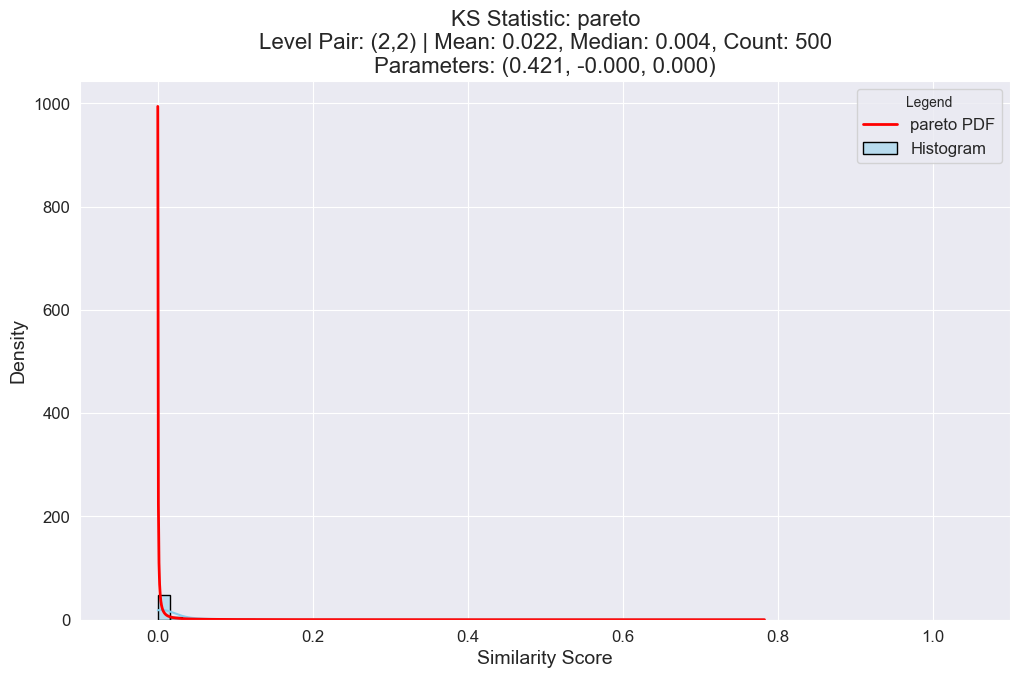

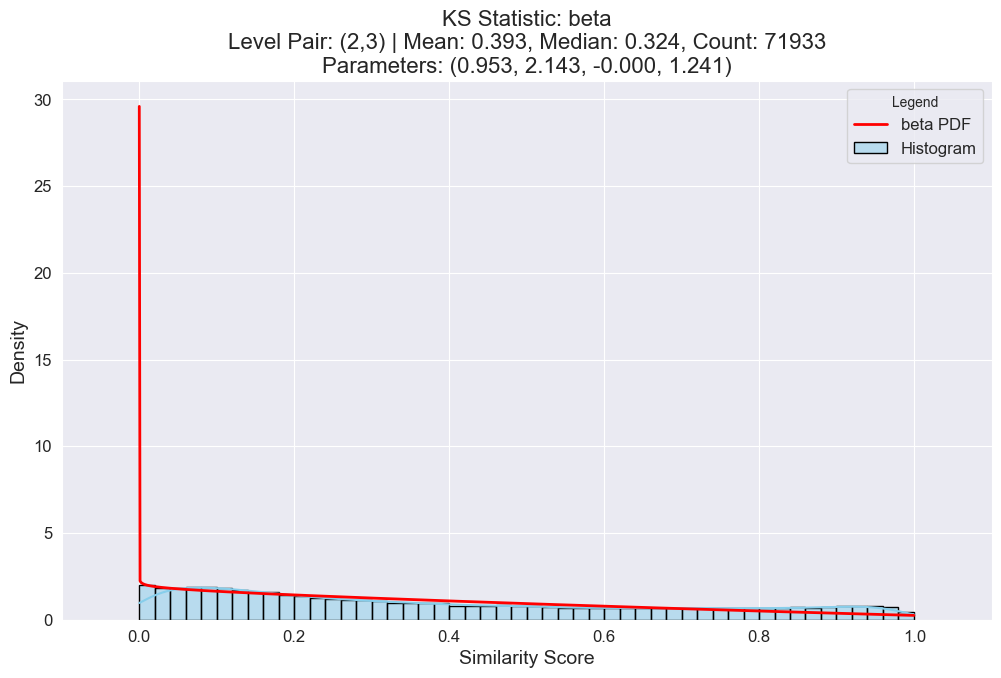

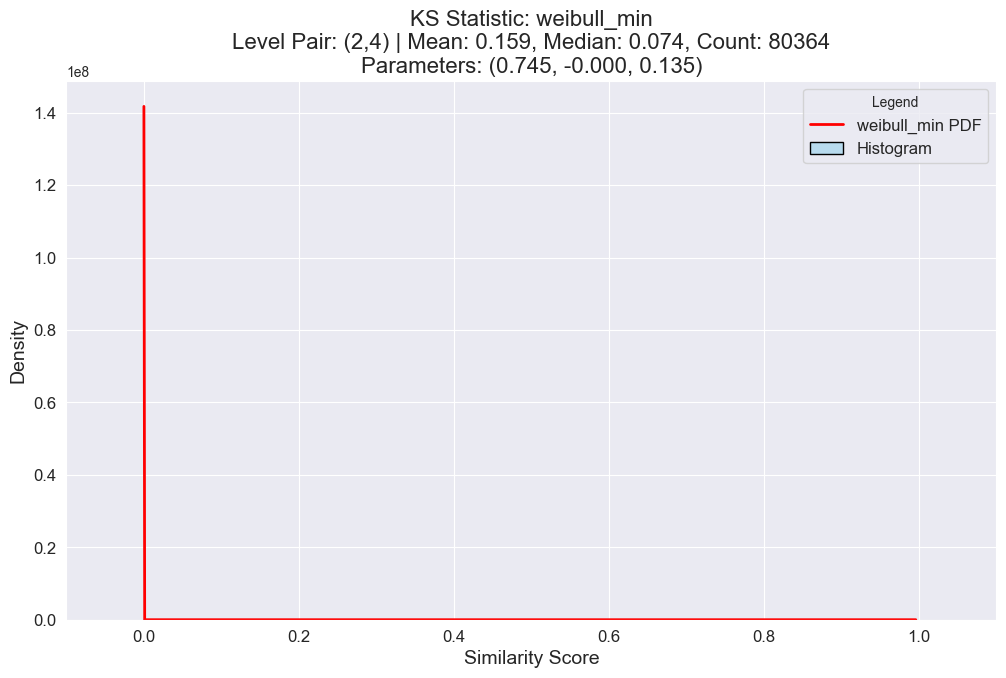

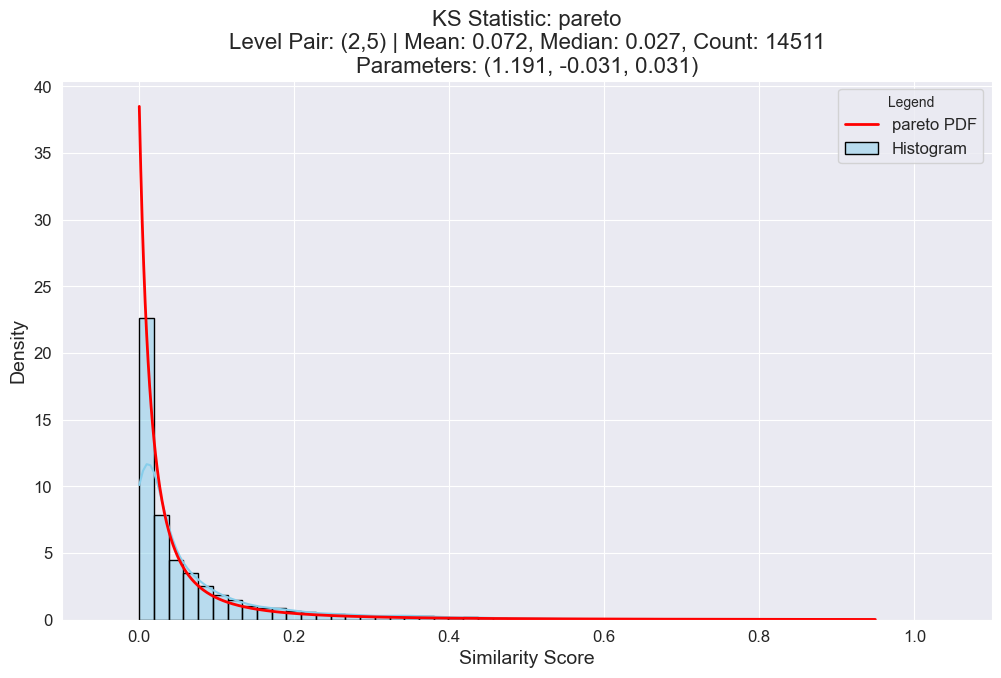

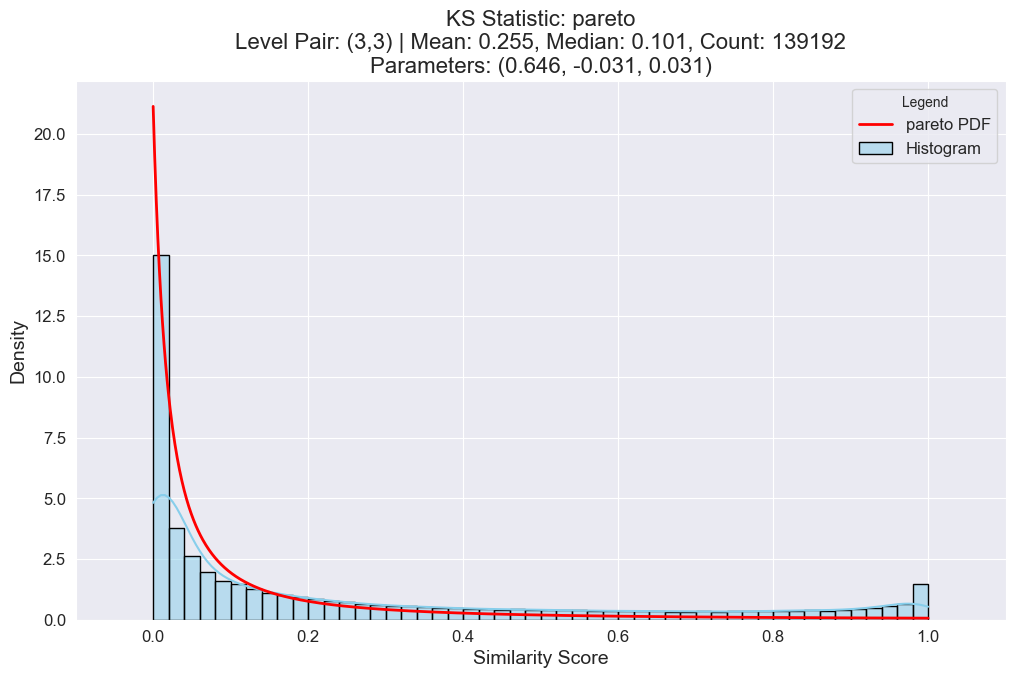

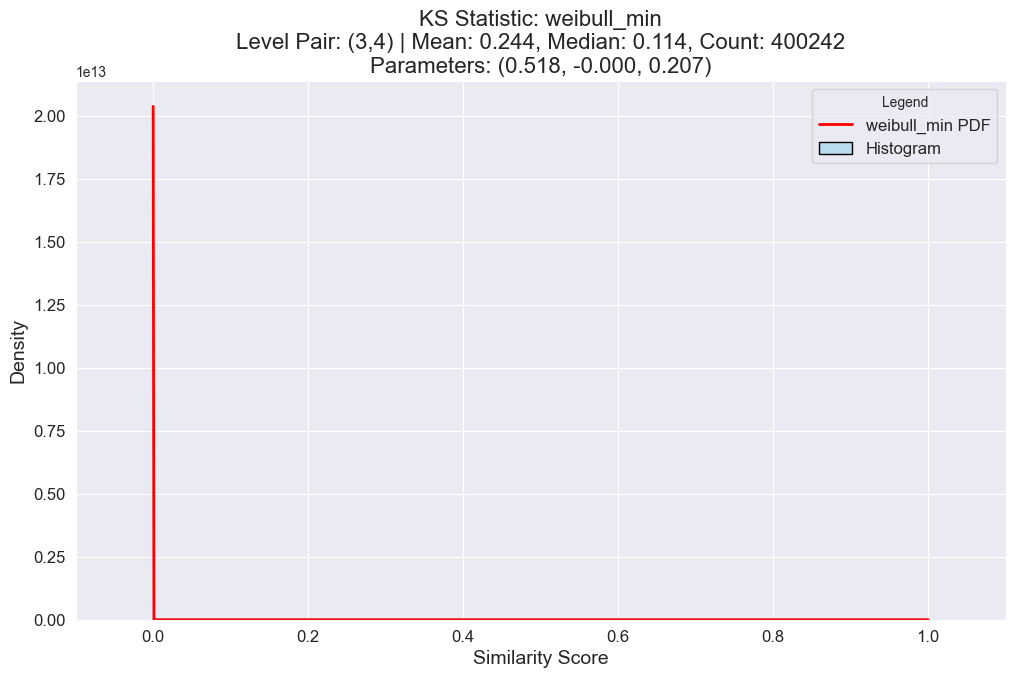

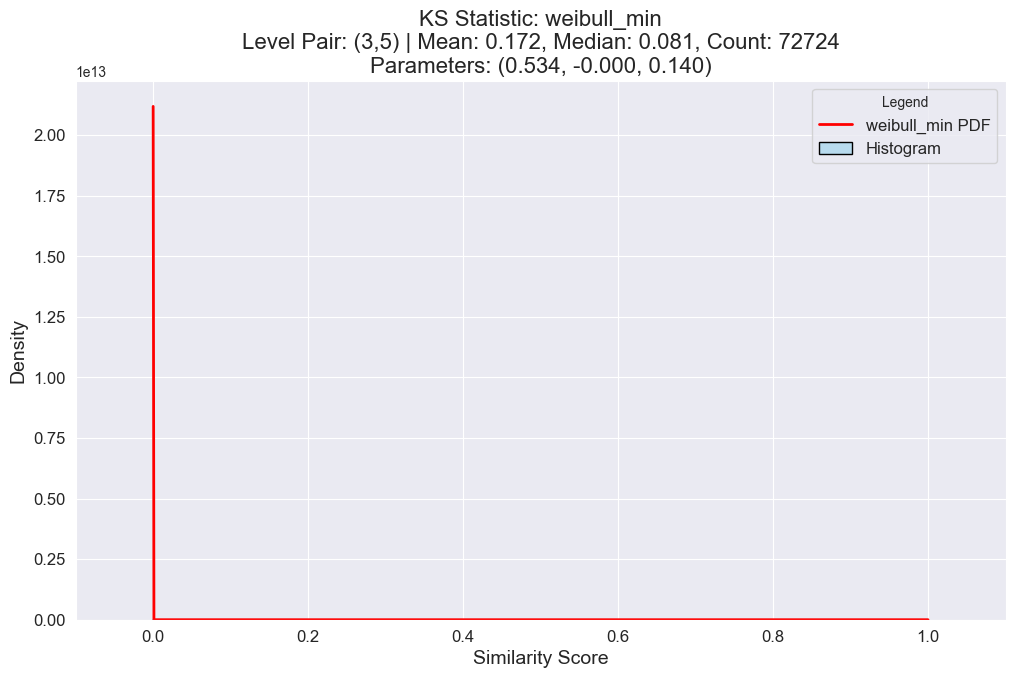

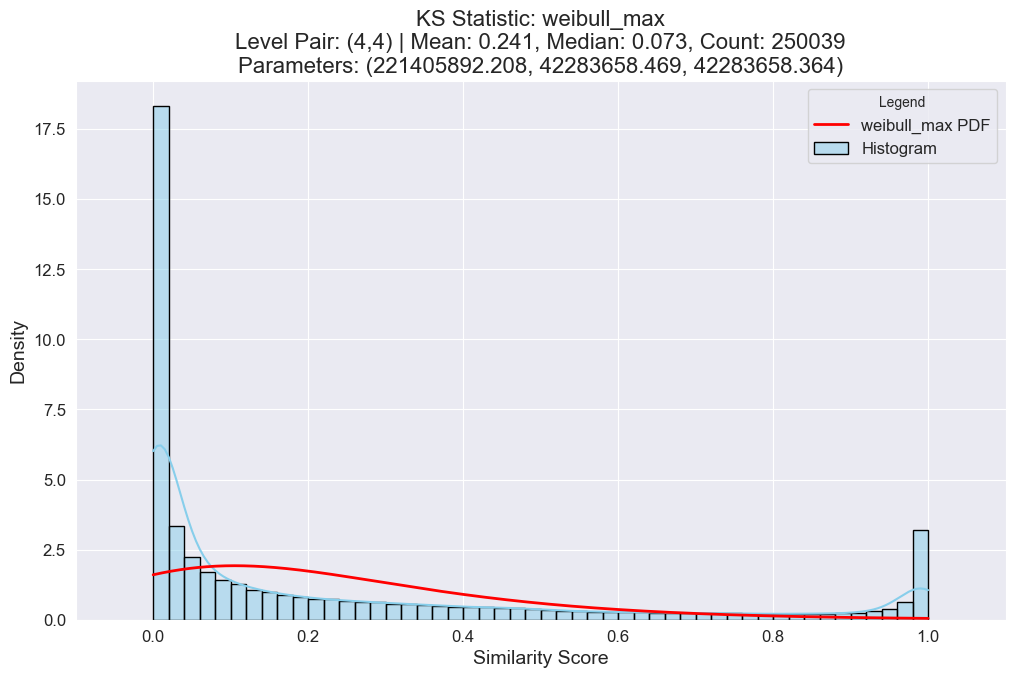

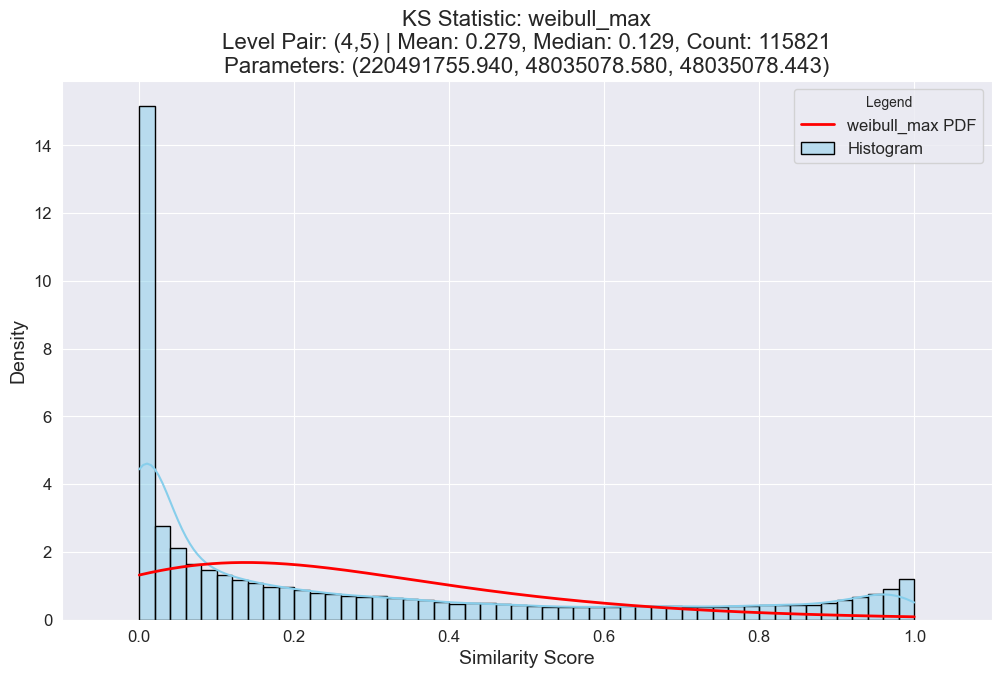

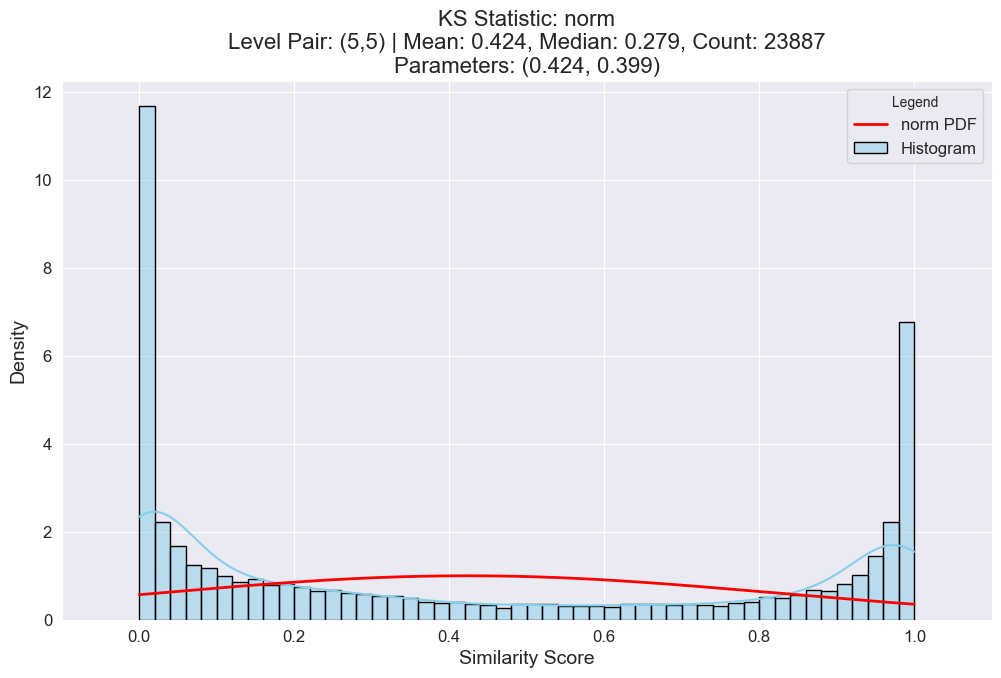

In [75]:
# Plotting Best-Fitting Distributions Based on KS Statistic
print("\nPlotting Best-Fitting Distributions Based on KS Statistic:")
plot_best_fit(
    summary_df=ks_summary_df,
    all_level_sims=all_level_sims_hung,
    criterion='KS Statistic',
    save_plots=False  # Set to True to save plots as PNG files
)


Plotting Best-Fitting Distributions Based on AIC:


/Users/macbook/UTILS/anaconda3/envs/massspecgym/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2036: RuntimeWarning: overflow encountered in divide
  place(output, cond, self._pdf(*goodargs) / scale)


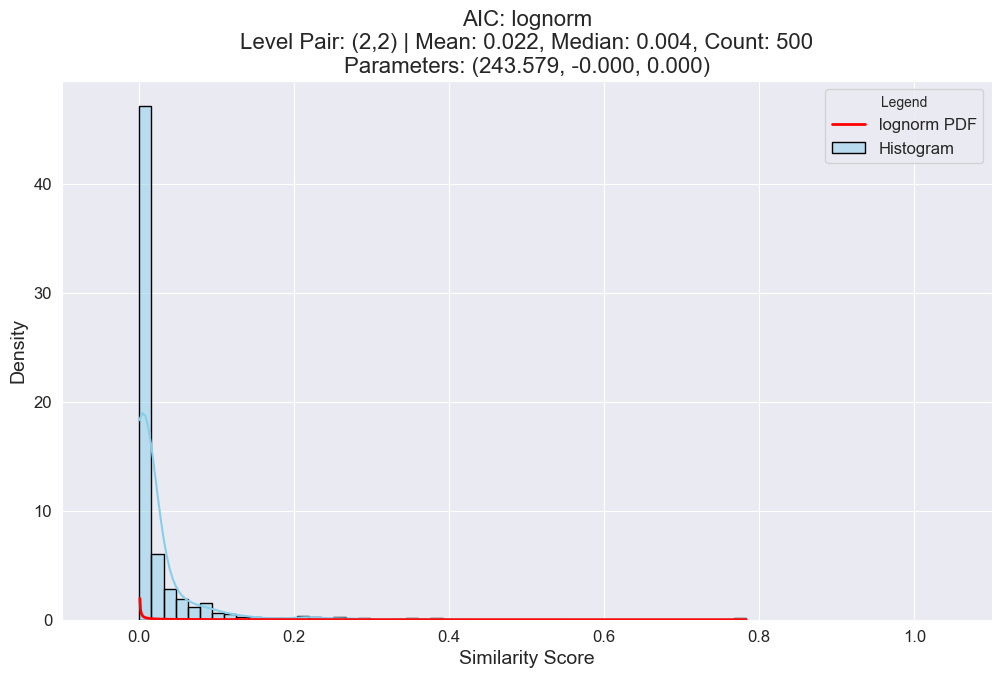

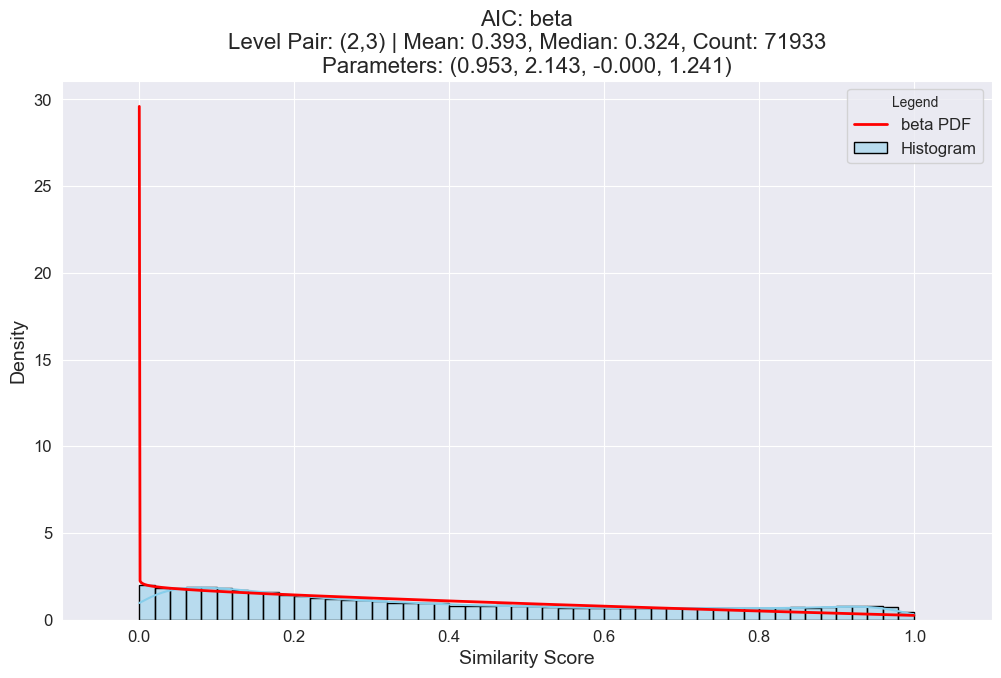

/Users/macbook/UTILS/anaconda3/envs/massspecgym/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2036: RuntimeWarning: overflow encountered in divide
  place(output, cond, self._pdf(*goodargs) / scale)


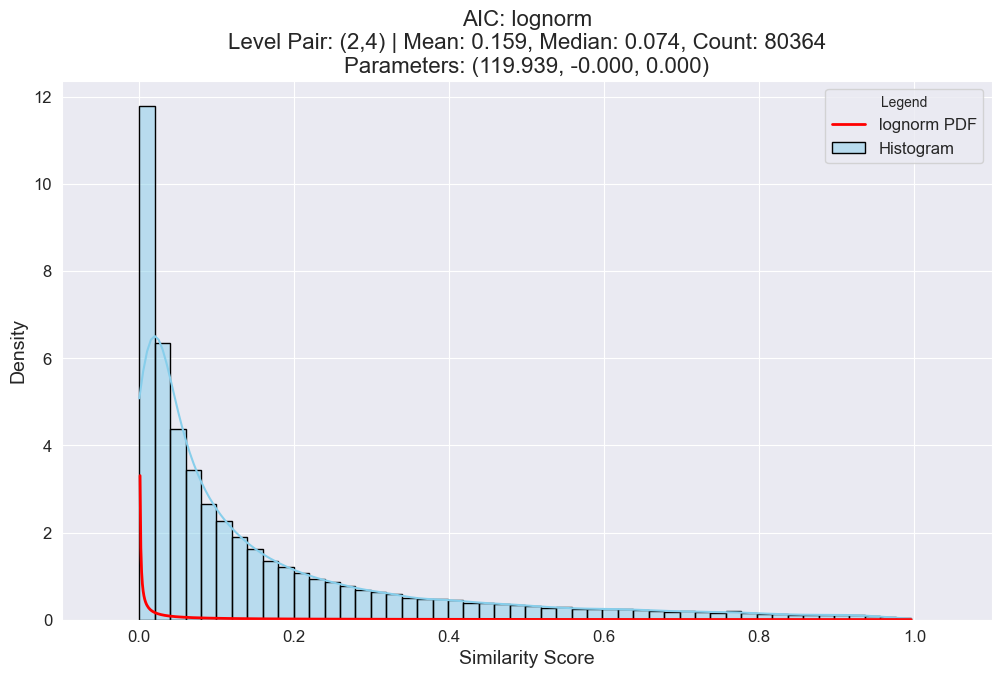

/Users/macbook/UTILS/anaconda3/envs/massspecgym/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2036: RuntimeWarning: overflow encountered in divide
  place(output, cond, self._pdf(*goodargs) / scale)


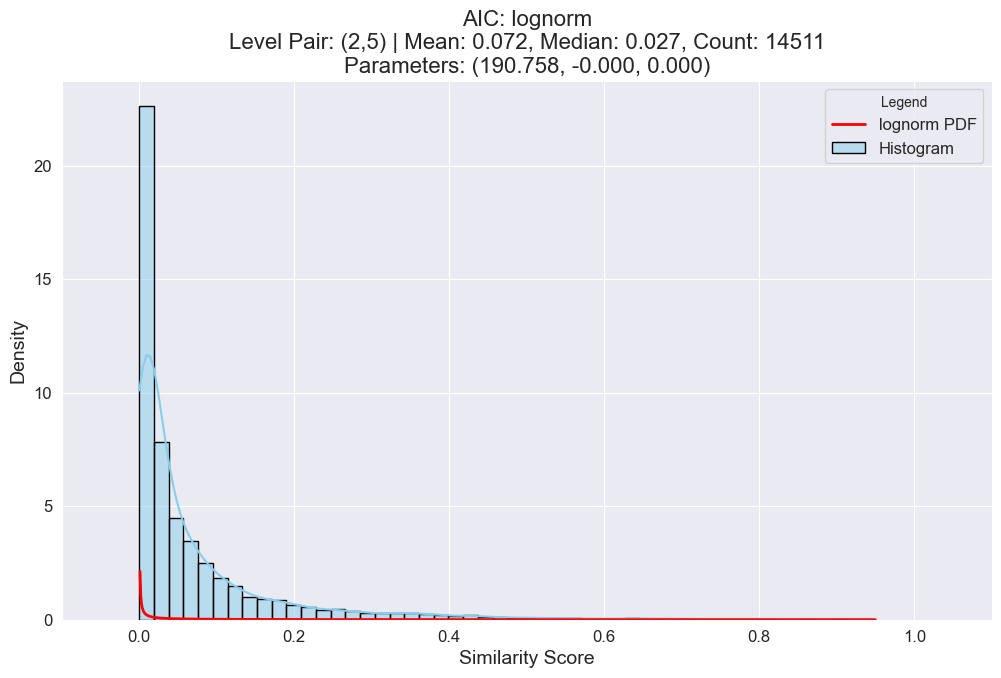

/Users/macbook/UTILS/anaconda3/envs/massspecgym/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2036: RuntimeWarning: overflow encountered in divide
  place(output, cond, self._pdf(*goodargs) / scale)


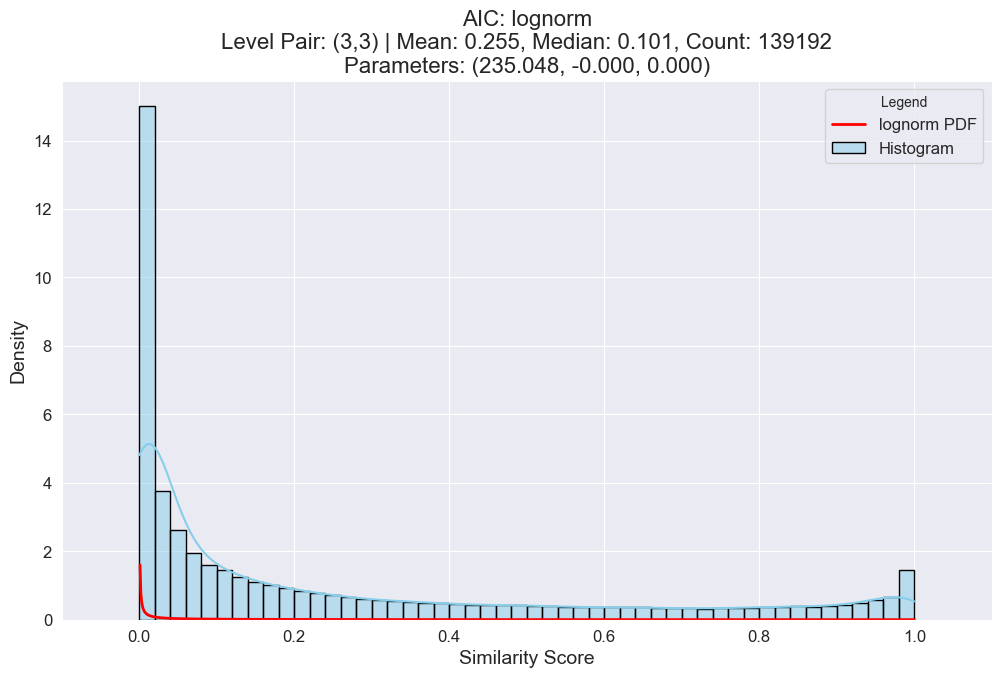

/Users/macbook/UTILS/anaconda3/envs/massspecgym/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2036: RuntimeWarning: overflow encountered in divide
  place(output, cond, self._pdf(*goodargs) / scale)


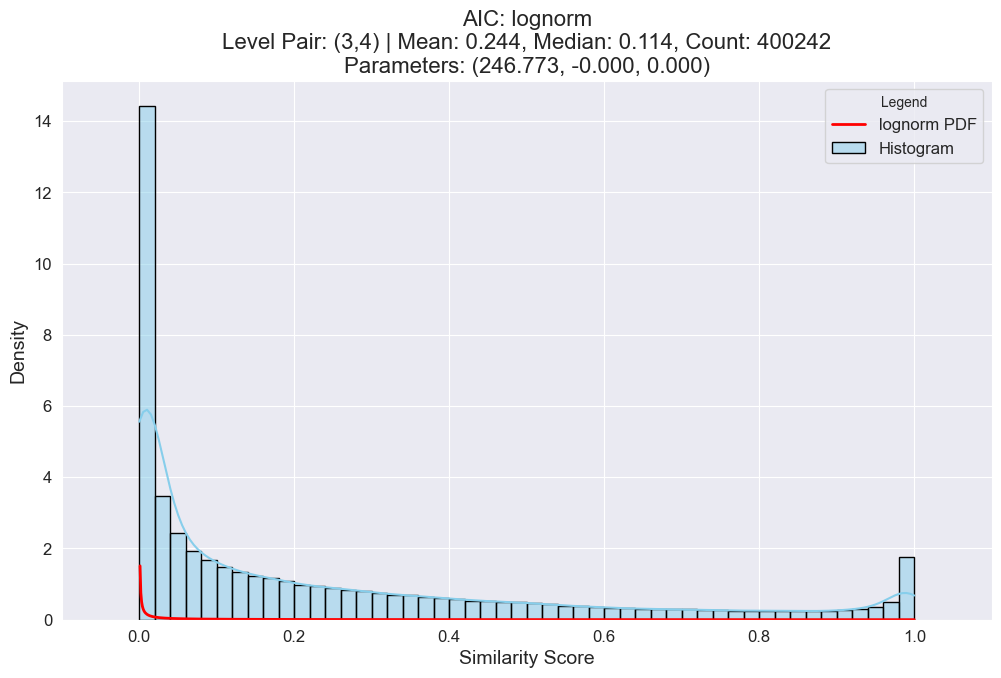

/Users/macbook/UTILS/anaconda3/envs/massspecgym/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2036: RuntimeWarning: overflow encountered in divide
  place(output, cond, self._pdf(*goodargs) / scale)


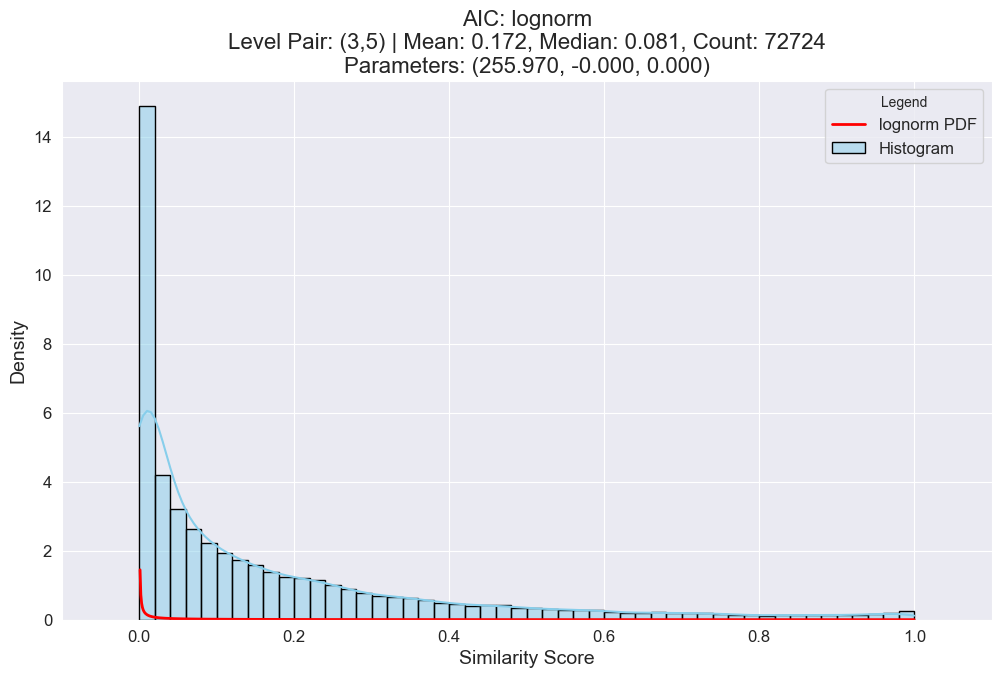

/Users/macbook/UTILS/anaconda3/envs/massspecgym/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2036: RuntimeWarning: overflow encountered in divide
  place(output, cond, self._pdf(*goodargs) / scale)


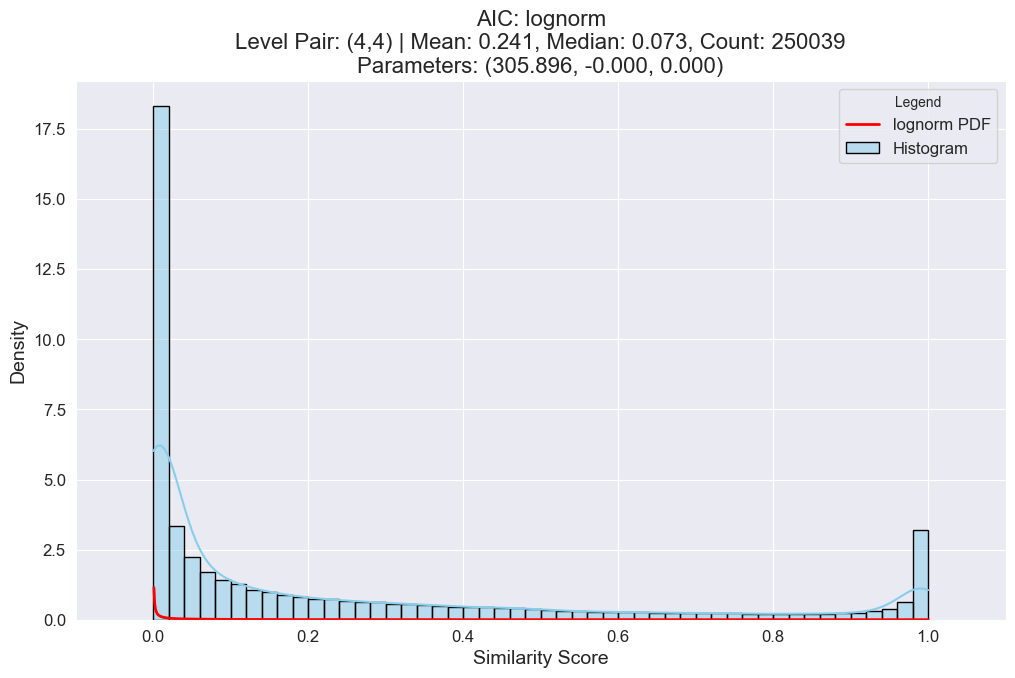

/Users/macbook/UTILS/anaconda3/envs/massspecgym/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2036: RuntimeWarning: overflow encountered in divide
  place(output, cond, self._pdf(*goodargs) / scale)


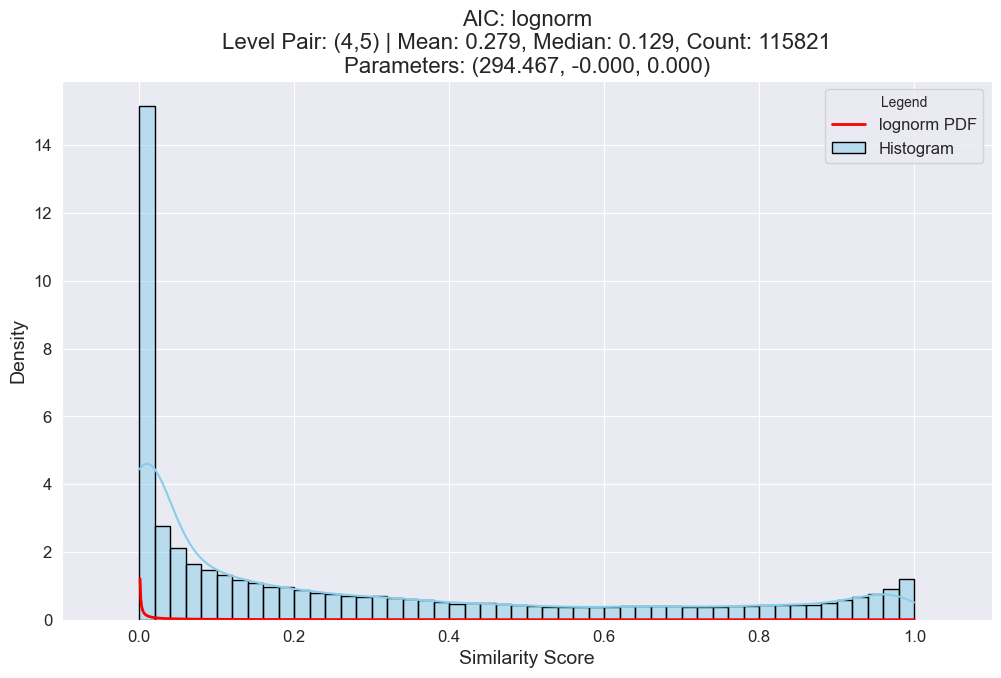

/Users/macbook/UTILS/anaconda3/envs/massspecgym/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2036: RuntimeWarning: overflow encountered in divide
  place(output, cond, self._pdf(*goodargs) / scale)


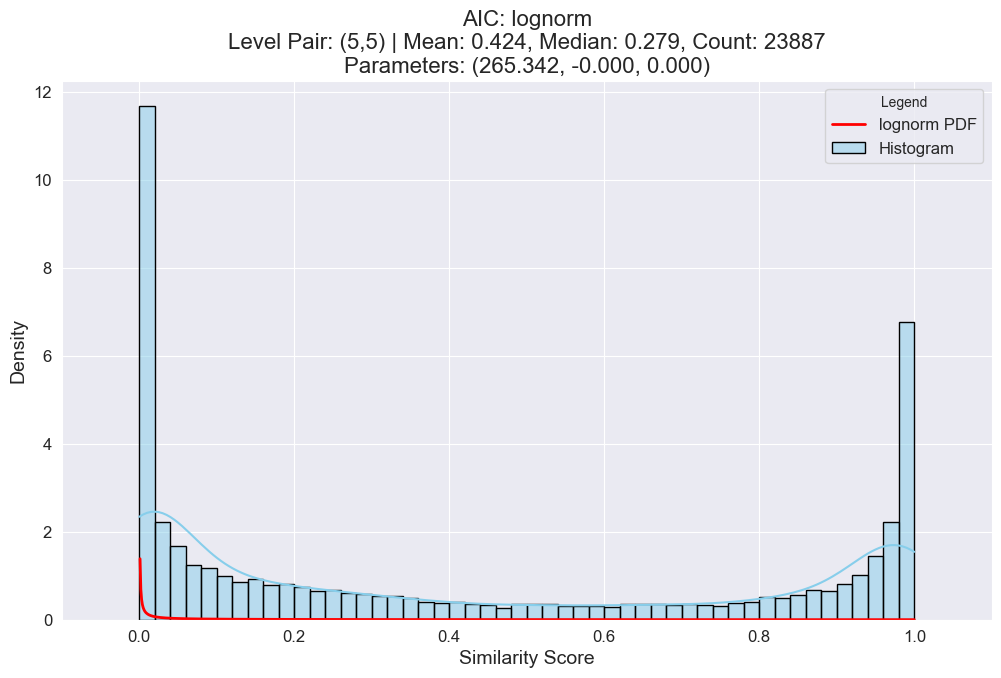

In [76]:
# Plotting Best-Fitting Distributions Based on AIC
print("\nPlotting Best-Fitting Distributions Based on AIC:")
plot_best_fit(
    summary_df=aic_summary_df,
    all_level_sims=all_level_sims_hung,
    criterion='AIC',
    save_plots=False  # Set to True to save plots as PNG files
)

Best fitting distribution: lognorm with KS Statistic=-90129.1291
Parameters: (243.57944913764544, -5e-324, 7.111037998600328e-43)


/Users/macbook/UTILS/anaconda3/envs/massspecgym/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:6626: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
/Users/macbook/UTILS/anaconda3/envs/massspecgym/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/macbook/UTILS/anaconda3/envs/massspecgym/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2036: RuntimeWarning: overflow encountered in divide
  place(output, cond, self._pdf(*goodargs) / scale)


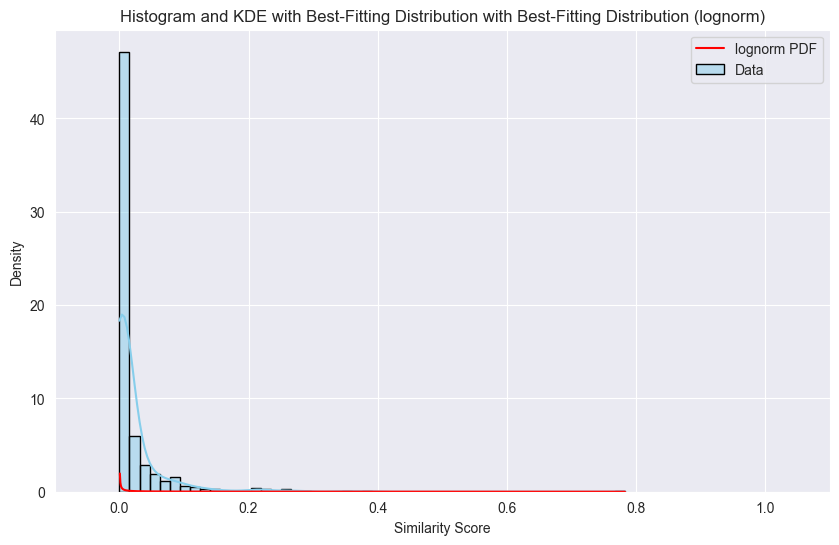

In [60]:
# Extract similarity scores for (2,2)
sims_2_2 = all_level_sims_hung.get((2, 2), [])

# Identify the best-fitting distribution
best_fit_dist = identify_best_fit_distribution(sims_2_2)

# Plot histogram with best-fitting distribution
if best_fit_dist is not None:
    plot_histogram_with_best_fit(sims_2_2, best_fit_dist, "Histogram and KDE with Best-Fitting Distribution")

In [38]:
# Generate the summary table
summary_table = summarize_all_level_pairs(all_level_sims_hung)

# Display the summary table
print("\nBest-Fitting Distributions for All Level Pairs:")
display(summary_table)


Fitting distributions for Level Pair (2, 3) with 71933 scores...
Best fitting distribution: beta with KS Statistic=0.0471
Parameters: (0.9529189668699778, 2.1430406223244924, -1.5703728020710403e-27, 1.2410506368266319)

Fitting distributions for Level Pair (2, 4) with 80364 scores...
Best fitting distribution: weibull_min with KS Statistic=0.0308
Parameters: (0.7453535431238589, -1.0705943309842896e-30, 0.1353824070491119)

Fitting distributions for Level Pair (3, 3) with 139192 scores...
Best fitting distribution: pareto with KS Statistic=0.1286
Parameters: (0.645866249499667, -0.03056486974734716, 0.030564869747347158)

Fitting distributions for Level Pair (3, 4) with 400242 scores...
Best fitting distribution: weibull_min with KS Statistic=0.1266
Parameters: (0.5183007081076441, -3.266010218672906e-28, 0.2070828461748363)

Fitting distributions for Level Pair (4, 4) with 250039 scores...
Best fitting distribution: weibull_max with KS Statistic=0.1961
Parameters: (221405892.2077192

,Level Pair,Best Fit Distribution
0,"(2, 3)",beta
1,"(2, 4)",weibull_min
2,"(3, 3)",pareto
3,"(3, 4)",weibull_min
4,"(4, 4)",weibull_max
5,"(2, 5)",pareto
6,"(3, 5)",weibull_min
7,"(4, 5)",weibull_max
8,"(5, 5)",norm
9,"(2, 2)",pareto


In [61]:
# Generate the summary table
summary_table = summarize_all_level_pairs(all_level_sims_hung)

# Display the summary table
print("\nBest-Fitting Distributions for All Level Pairs:")
display(summary_table)


Fitting distributions for Level Pair (2, 3) with 71933 scores...
Best fitting distribution: beta with KS Statistic=-3654.4430
Parameters: (0.9529189668699778, 2.1430406223244924, -1.5703728020710403e-27, 1.2410506368266319)

Fitting distributions for Level Pair (2, 4) with 80364 scores...
Best fitting distribution: lognorm with KS Statistic=-2642030.9831
Parameters: (119.93913359446574, -5e-324, 1.4651966691861858e-10)

Fitting distributions for Level Pair (3, 3) with 139192 scores...
Best fitting distribution: lognorm with KS Statistic=-22126466.5148
Parameters: (235.0476227806456, -5e-324, 3.1194820261185726e-38)

Fitting distributions for Level Pair (3, 4) with 400242 scores...
Best fitting distribution: lognorm with KS Statistic=-71488527.9141
Parameters: (246.77280449042033, -5e-324, 1.607259254084645e-42)

Fitting distributions for Level Pair (4, 4) with 250039 scores...
Best fitting distribution: lognorm with KS Statistic=-78056397.9610
Parameters: (305.89579092585143, -5e-324,

,Level Pair,Best Fit Distribution
0,"(2, 3)",beta
1,"(2, 4)",lognorm
2,"(3, 3)",lognorm
3,"(3, 4)",lognorm
4,"(4, 4)",lognorm
5,"(2, 5)",lognorm
6,"(3, 5)",lognorm
7,"(4, 5)",lognorm
8,"(5, 5)",lognorm
9,"(2, 2)",lognorm


In [87]:
all_level_sims_hung.keys()

dict_keys([(2, 3), (2, 4), (3, 3), (3, 4), (4, 4), (2, 5), (3, 5), (4, 5), (5, 5), (2, 2)])

In [88]:
len(all_level_sims_hung[(2,3)])

71933

In [89]:
type(all_level_sims_hung[(2,3)])

list

In [90]:
all_level_sims_hung[(2,3)][0]

0.09482385185445195

In [91]:
type(all_level_sims_hung[(2,3)][0])

float

In [92]:
len(all_level_sims_hung[(2,2)])

500

In [93]:
all_level_sims_hung[(2,2)][0]

0.0

## Correlation

In [94]:
# Convert the dictionary to a DataFrame
data = []
for level_pair, sims in all_level_sims_hung.items():
    lvlA, lvlB = level_pair
    data.append({
        'Level_A': lvlA,
        'Level_B': lvlB,
        'Similarity_Scores': sims
    })

df = pd.DataFrame(data)

In [95]:
# Function to compute statistics
def compute_statistics(row):
    sims = row['Similarity_Scores']
    return pd.Series({
        'Mean_Similarity': np.mean(sims),
        'Median_Similarity': np.median(sims),
        'Std_Similarity': np.std(sims),
        'Count': len(sims),
        'Min_Level': min(row['Level_A'], row['Level_B']),
        'Max_Level': max(row['Level_A'], row['Level_B']),
        'Avg_Level': (row['Level_A'] + row['Level_B']) / 2,
        'Level_Difference': abs(row['Level_A'] - row['Level_B'])
    })

# Apply the function to each row
stats_df = df.apply(compute_statistics, axis=1)

# Combine with original DataFrame if needed
df_stats = pd.concat([df, stats_df], axis=1)

# Display the DataFrame with statistics
display(df_stats)

,Level_A,Level_B,Similarity_Scores,Mean_Similarity,Median_Similarity,Std_Similarity,Count,Min_Level,Max_Level,Avg_Level,Level_Difference
0,2,3,"[0.09482385185445195, 0.8912841082529714, 0.00...",0.392914,0.323588,0.294467,71933.0,2.0,3.0,2.5,1.0
1,2,4,"[0.005919828689851691, 0.001820470000688197, 0...",0.159200,0.074344,0.202640,80364.0,2.0,4.0,3.0,2.0
2,3,3,"[0.07014378596781198, 0.5454345735326523, 0.0,...",0.255479,0.100533,0.313105,139192.0,3.0,3.0,3.0,0.0
3,3,4,"[0.5756669539237175, 0.1869511803622772, 0.082...",0.243716,0.114016,0.294008,400242.0,3.0,4.0,3.5,1.0
4,4,4,"[0.4143261690514941, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.241203,0.072792,0.322015,250039.0,4.0,4.0,4.0,0.0
5,2,5,"[0.05456264309397094, 0.0, 0.05503910775680427...",0.071939,0.026582,0.114875,14511.0,2.0,5.0,3.5,3.0
6,3,5,"[0.0, 0.16923158673220134, 0.18544784226009509...",0.171689,0.080569,0.221989,72724.0,3.0,5.0,4.0,2.0
7,4,5,"[0.2922678667121452, 0.4296082776067361, 0.414...",0.278966,0.128909,0.323408,115821.0,4.0,5.0,4.5,1.0
8,5,5,"[0.0034051087972177237, 0.27212079082509977, 0...",0.423661,0.279100,0.398949,23887.0,5.0,5.0,5.0,0.0
9,2,2,"[0.0, 0.0006518641256617711, 0.000999703420620...",0.021749,0.003839,0.056372,500.0,2.0,2.0,2.0,0.0


In [96]:
# Selecting relevant columns for correlation
corr_columns = ['Avg_Level', 'Level_Difference', 'Mean_Similarity', 'Median_Similarity', 'Std_Similarity']

# Compute the correlation matrix
corr_matrix = df_stats[corr_columns].corr()

# Display the correlation matrix
print("Correlation Matrix:")
display(corr_matrix)

Correlation Matrix:


,Avg_Level,Level_Difference,Mean_Similarity,Median_Similarity,Std_Similarity
Avg_Level,1.000000e+00,-7.691851e-17,0.469579,0.245332,0.645486
Level_Difference,-7.691851e-17,1.000000e+00,-0.389419,-0.254178,-0.437685
Mean_Similarity,4.695792e-01,-3.894185e-01,1.000000,0.920084,0.916144
Median_Similarity,2.453319e-01,-2.541781e-01,0.920084,1.000000,0.687464
Std_Similarity,6.454859e-01,-4.376849e-01,0.916144,0.687464,1.000000


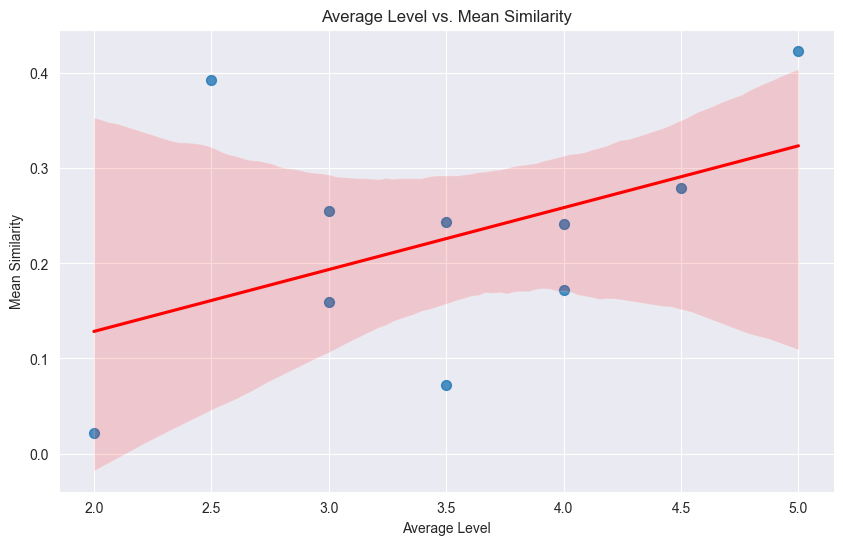

In [97]:
plt.figure(figsize=(10, 6))
sns.regplot(x='Avg_Level', y='Mean_Similarity', data=df_stats, scatter_kws={'s':50}, line_kws={'color':'red'})
plt.title('Average Level vs. Mean Similarity')
plt.xlabel('Average Level')
plt.ylabel('Mean Similarity')
plt.show()

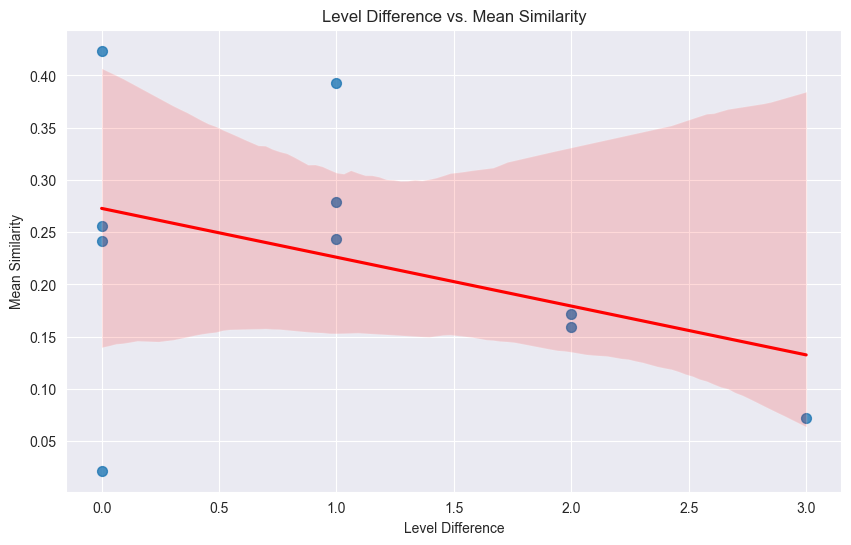

In [98]:
plt.figure(figsize=(10, 6))
sns.regplot(x='Level_Difference', y='Mean_Similarity', data=df_stats, scatter_kws={'s':50}, line_kws={'color':'red'})
plt.title('Level Difference vs. Mean Similarity')
plt.xlabel('Level Difference')
plt.ylabel('Mean Similarity')
plt.show()

/var/folders/bl/73ckjztx5js4cc0cj85qgvlm0000gn/T/ipykernel_22147/3728132525.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Avg_Level', y='Mean_Similarity', data=df_stats, palette='Set2')


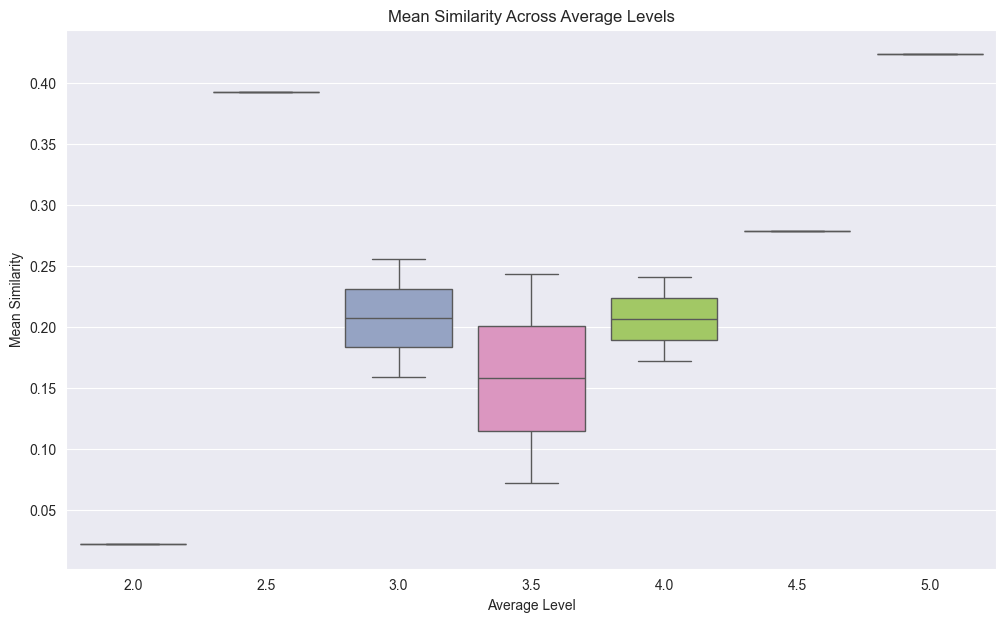

In [99]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Avg_Level', y='Mean_Similarity', data=df_stats, palette='Set2')
plt.title('Mean Similarity Across Average Levels')
plt.xlabel('Average Level')
plt.ylabel('Mean Similarity')
plt.show()

/var/folders/bl/73ckjztx5js4cc0cj85qgvlm0000gn/T/ipykernel_22147/933056188.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Level_Difference', y='Median_Similarity', data=df_stats, palette='Set1')


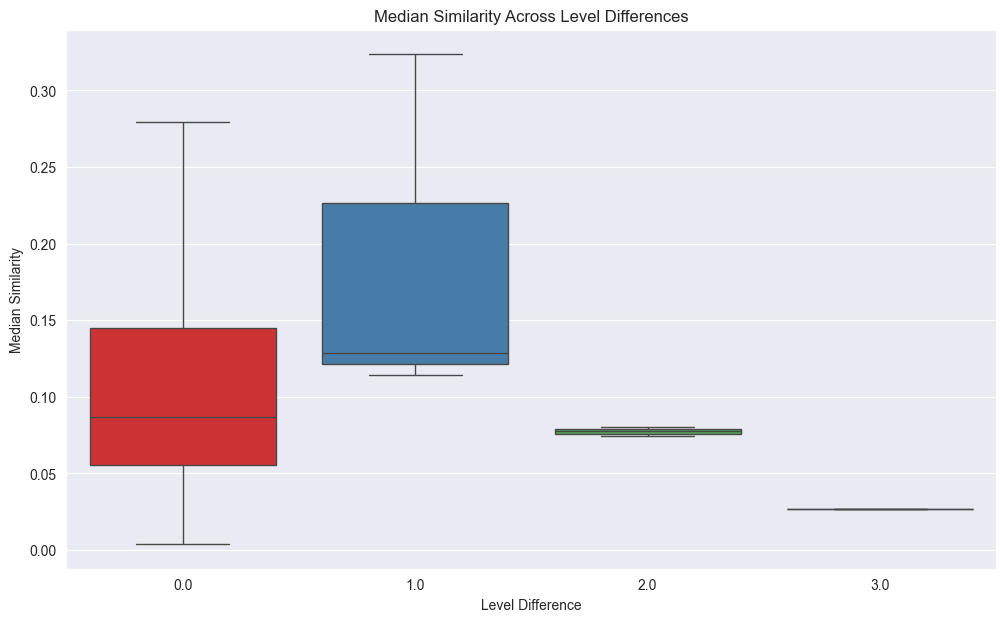

In [101]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Level_Difference', y='Median_Similarity', data=df_stats, palette='Set1')
plt.title('Median Similarity Across Level Differences')
plt.xlabel('Level Difference')
plt.ylabel('Median Similarity')
plt.show()

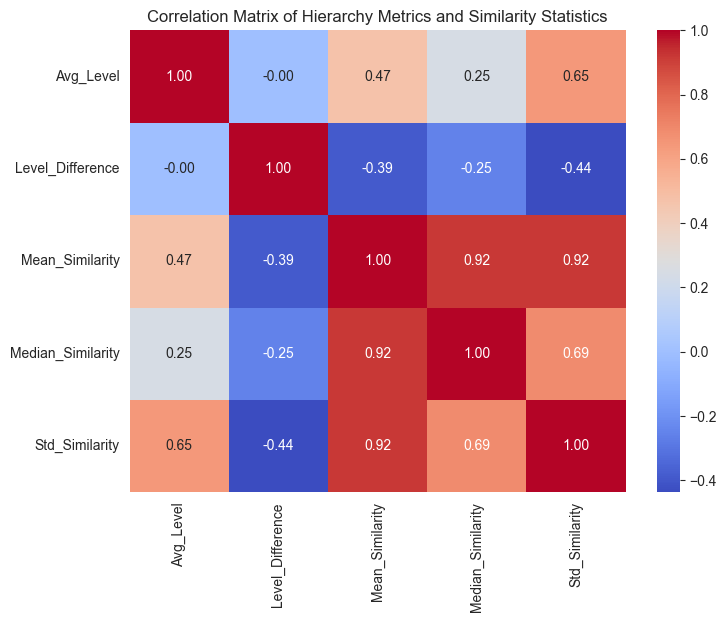

In [102]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Hierarchy Metrics and Similarity Statistics')
plt.show()

## DreaMS

In [36]:
embeddings_dict = load_embeddings(
    file_path="/Users/macbook/CODE/Majer:MassSpecGym/data/MSn/MSn_DreaMS.h5",
    identifier_col="identifiers",
    embedding_col="embeddings"
)

In [37]:
# MS-Level Pair Analysis (embedding-based)
all_level_sims_hung = defaultdict(list)

for tree in msn_dataset.trees:
    level_sims_dict = compute_pairwise_similarity_by_mslevel(
        tree, use_embedding=True, sim_fn=None, embeddings_dict=embeddings_dict
    )
    for (lvlA, lvlB), simvals in level_sims_dict.items():
        if (lvlA, lvlB) not in all_level_sims_hung:
            all_level_sims_hung[(lvlA, lvlB)] = []
        all_level_sims_hung[(lvlA, lvlB)].extend(simvals)

In [38]:
# MS2 <-> MS2 (embedding-based) with limited pairs
ms2_sims_hung = compute_same_level_similarity_limited(
    msn_dataset,
    target_level=2,
    use_embedding=True,
    sim_fn=None,
    embeddings_dict=embeddings_dict,
    max_pairs=5000 
)

In [39]:
# Initialize (2,2) if not present
if (2, 2) not in all_level_sims_hung:
    all_level_sims_hung[(2, 2)] = []

all_level_sims_hung[(2, 2)].extend(ms2_sims_hung)

In [40]:
# Print average for each level pair
for level_pair, vals in all_level_sims_hung.items():
    stats_lv = summarize_similarity_distribution(vals)
    print(f"Level pair {level_pair} -> {stats_lv}")

Level pair (2, 3) -> {'mean': 0.36960604786872864, 'std': 0.18211105465888977, 'median': 0.35392341017723083, 'count': 71933, 'shapiro_p': nan, 'ks_p': 1.3672070184790992e-77, 'is_normal': False}
Level pair (2, 4) -> {'mean': 0.21595095098018646, 'std': 0.13768118619918823, 'median': 0.20510858297348022, 'count': 80364, 'shapiro_p': nan, 'ks_p': 2.472693430814236e-73, 'is_normal': False}
Level pair (3, 3) -> {'mean': 0.3400874137878418, 'std': 0.23485657572746277, 'median': 0.3094925582408905, 'count': 139192, 'shapiro_p': nan, 'ks_p': 0.0, 'is_normal': False}
Level pair (3, 4) -> {'mean': 0.3061775863170624, 'std': 0.22588127851486206, 'median': 0.26777011156082153, 'count': 400242, 'shapiro_p': nan, 'ks_p': 0.0, 'is_normal': False}
Level pair (4, 4) -> {'mean': 0.34772124886512756, 'std': 0.25415658950805664, 'median': 0.2987461984157562, 'count': 250039, 'shapiro_p': nan, 'ks_p': 0.0, 'is_normal': False}
Level pair (2, 5) -> {'mean': 0.21092155575752258, 'std': 0.12815092504024506, 

In [41]:
# Summarize and perform statistical tests for hungarian_fn similarities
print("\n--- Statistical Analysis for Hungarian Similarity Function ---")
comparison_results_hung = perform_statistical_tests_with_effect_sizes(all_level_sims_hung, alpha=0.05)
report_comparison_results_with_effect_sizes(comparison_results_hung)


--- Statistical Analysis for Hungarian Similarity Function ---
Group 1 Group 2           Test Used    Statistic       p-value  Adjusted Alpha  Significant  Effect Size          Effect Size Type
    2-3     2-4 Mann-Whitney U test 4.315303e+09  0.000000e+00        0.001111         True    -0.492972 Rank-Biserial Correlation
    3-3     2-2 Mann-Whitney U test 5.400329e+08  0.000000e+00        0.001111         True    -0.551908 Rank-Biserial Correlation
    3-4     4-4 Mann-Whitney U test 4.589233e+10  0.000000e+00        0.001111         True     0.082851 Rank-Biserial Correlation
    3-4     2-5 Mann-Whitney U test 3.562181e+09  0.000000e+00        0.001111         True    -0.226665 Rank-Biserial Correlation
    3-4     4-5 Mann-Whitney U test 1.755883e+10  0.000000e+00        0.001111         True     0.242442 Rank-Biserial Correlation
    3-4     5-5 Mann-Whitney U test 2.386486e+09  0.000000e+00        0.001111         True     0.500766 Rank-Biserial Correlation
    3-4     2-2 Man

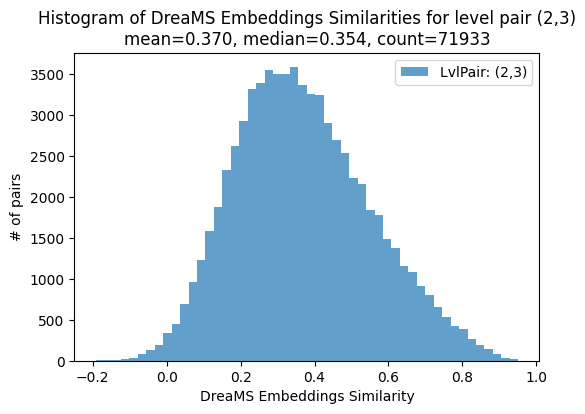

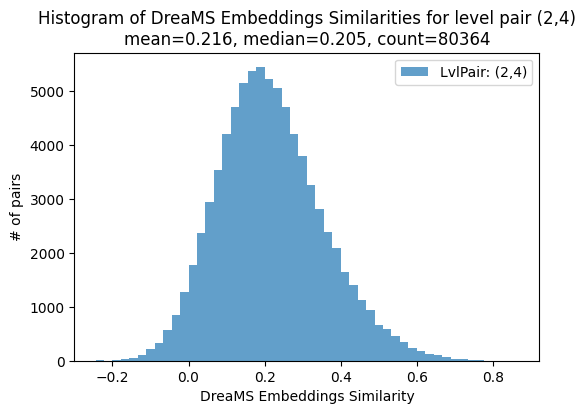

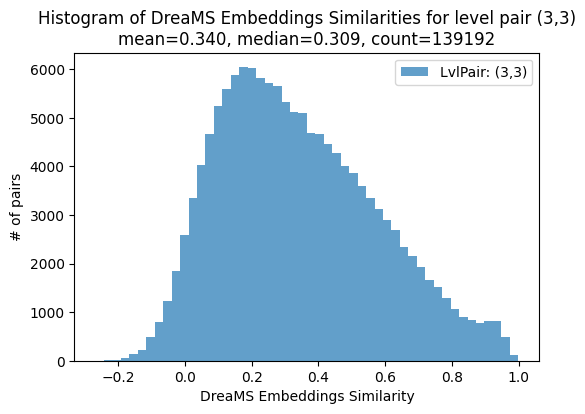

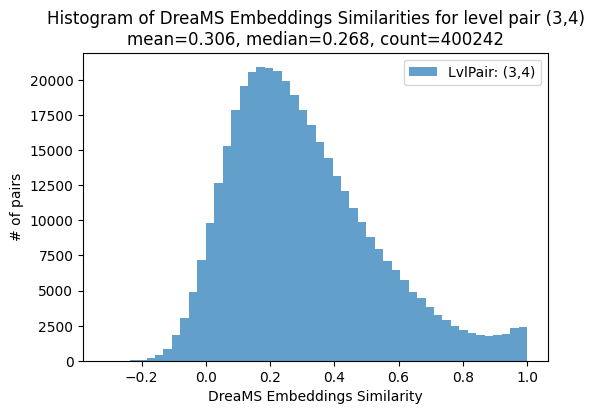

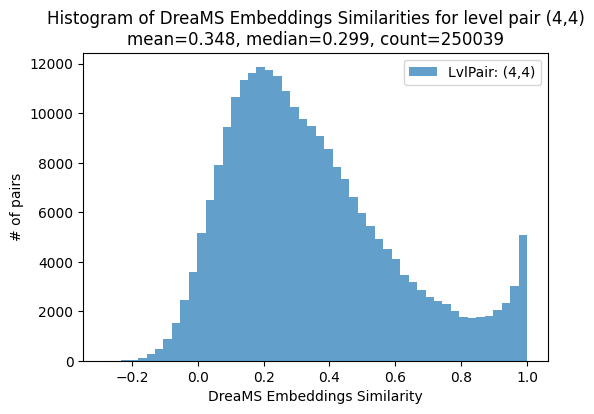

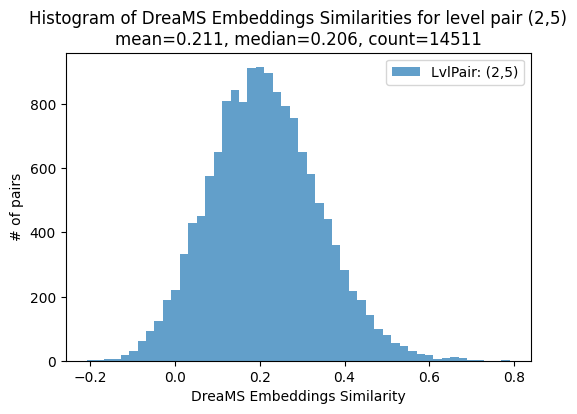

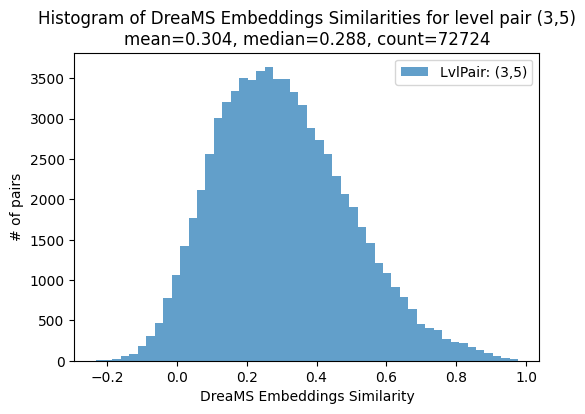

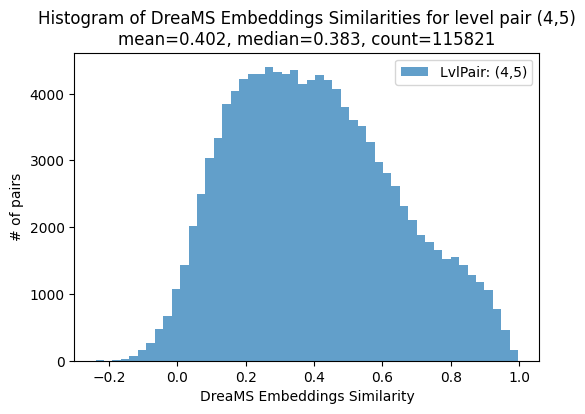

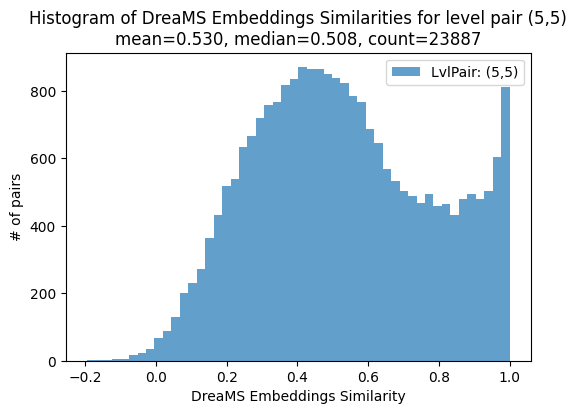

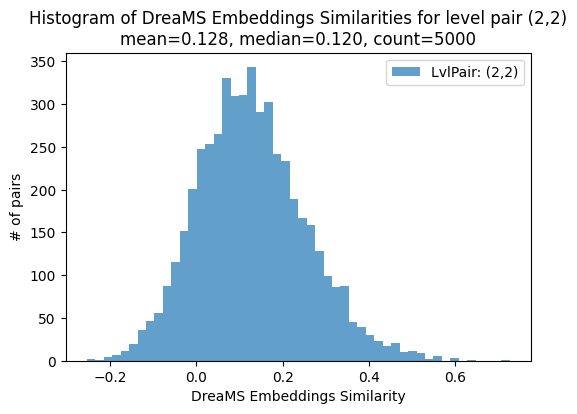

In [42]:
# Optionally plot each level pair in a separate figure:
plot_histograms_by_level_pairs(all_level_sims_hung, mode="DreaMS Embeddings")

In [14]:
def hungarian_fn(specA, specB):
    (sc, _) = compute_cosine_hungarian_score(specA, specB, tolerance=0.1)
    return (sc, 0)

ad_sims_hung = []
sib_sims_hung = []
rand_sims_hung = []

In [15]:
for tree in msn_dataset.trees:
    # Anc-Desc
    sims = compute_ancestor_descendant_similarity(
        tree, use_embedding=False, sim_fn=hungarian_fn
    )
    ad_sims_hung.extend(sims)

    # Siblings
    siblings = compute_sibling_similarity(
        tree, use_embedding=False, sim_fn=hungarian_fn
    )
    sib_sims_hung.extend(siblings)

rand_sims_hung = random_node_pairs(msn_dataset, num_pairs=5000,
                                   use_embedding=False, sim_fn=hungarian_fn)

In [16]:
stats_ad_hung = summarize_similarity_distribution(ad_sims_hung)
stats_sib_hung = summarize_similarity_distribution(sib_sims_hung)
stats_rand_hung = summarize_similarity_distribution(rand_sims_hung)

print("Ancestor-Descendant (Hungarian Cosine) stats:", stats_ad_hung)
print("Sibling (Hungarian Cosine) stats:", stats_sib_hung)
print("Random pairs (Hungarian Cosine) stats:", stats_rand_hung)

Ancestor-Descendant (Hungarian Cosine) stats: {'mean': 0.41311503931629406, 'std': 0.2766341832752525, 'median': 0.358482554701118, 'count': 166808, 'shapiro_p': nan, 'ks_p': 0.0, 'is_normal': False}
Sibling (Hungarian Cosine) stats: {'mean': 0.2600110815415143, 'std': 0.3069481175822487, 'median': 0.11463458831076889, 'count': 173661, 'shapiro_p': nan, 'ks_p': 0.0, 'is_normal': False}
Random pairs (Hungarian Cosine) stats: {'mean': 0.02776404450850912, 'std': 0.08324445757657506, 'median': 0.0015620962330701858, 'count': 5000, 'shapiro_p': 8.093267018062923e-86, 'ks_p': 0.0, 'is_normal': False}


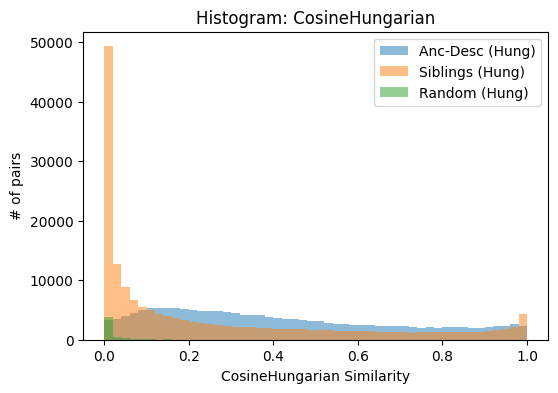

In [17]:
plot_histograms({
    "Anc-Desc (Hung)": ad_sims_hung,
    "Siblings (Hung)": sib_sims_hung,
    "Random (Hung)": rand_sims_hung
}, title="Histogram: CosineHungarian", xlabel="CosineHungarian Similarity")

In [18]:
# MS-Level Pair Analysis
all_level_sims = defaultdict(list)

for tree in msn_dataset.trees:
    level_sims_dict = compute_pairwise_similarity_by_mslevel(
        tree, use_embedding=False, sim_fn=hungarian_fn
    )
    for (lvlA, lvlB), simvals in level_sims_dict.items():
        all_level_sims[(lvlA, lvlB)].extend(simvals)


In [22]:
# Print average for each level pair
for level_pair, vals in all_level_sims.items():
    stats_lv = summarize_similarity_distribution_aggregated(vals)
    print(f"Level pair {level_pair} -> {stats_lv}")

Level pair (2, 3) -> {'mean': 0.39291368614045286, 'std': 0.29446695517700344, 'median': 0.3235879346057741, 'count': 71933}
Level pair (2, 4) -> {'mean': 0.15920017039996986, 'std': 0.2026399596469752, 'median': 0.07434368995850654, 'count': 80364}
Level pair (3, 3) -> {'mean': 0.2554785019529586, 'std': 0.31310530745819204, 'median': 0.10053266364833399, 'count': 139192}
Level pair (3, 4) -> {'mean': 0.24371597288093041, 'std': 0.29400848616911196, 'median': 0.11401620645957766, 'count': 400242}
Level pair (4, 4) -> {'mean': 0.24120319032465876, 'std': 0.32201527994996815, 'median': 0.0727915126063649, 'count': 250039}
Level pair (2, 5) -> {'mean': 0.07193860604153023, 'std': 0.11487458429477933, 'median': 0.02658169835400203, 'count': 14511}
Level pair (3, 5) -> {'mean': 0.17168872250009667, 'std': 0.22198916240377284, 'median': 0.08056879358545516, 'count': 72724}
Level pair (4, 5) -> {'mean': 0.27896573058598184, 'std': 0.3234083841746633, 'median': 0.12890938206511526, 'count': 1

In [19]:
# Perform statistical tests
comparison_results = perform_statistical_tests(all_level_sims, alpha=0.05)

# Report the results
report_comparison_results(comparison_results)

Group 1 Group 2           Test Used    Statistic       p-value  Adjusted Alpha  Significant
    2-3     2-4 Mann-Whitney U test 4.418347e+09  0.000000e+00        0.001389         True
    3-5     4-5 Mann-Whitney U test 3.736132e+09  0.000000e+00        0.001389         True
    2-5     5-5 Mann-Whitney U test 9.509983e+07  0.000000e+00        0.001389         True
    2-5     4-5 Mann-Whitney U test 5.945492e+08  0.000000e+00        0.001389         True
    2-5     3-5 Mann-Whitney U test 3.983101e+08  0.000000e+00        0.001389         True
    4-4     5-5 Mann-Whitney U test 2.233256e+09  0.000000e+00        0.001389         True
    4-4     4-5 Mann-Whitney U test 1.336197e+10  0.000000e+00        0.001389         True
    3-4     5-5 Mann-Whitney U test 3.752695e+09  0.000000e+00        0.001389         True
    3-4     3-5 Mann-Whitney U test 1.599715e+10  0.000000e+00        0.001389         True
    3-4     2-5 Mann-Whitney U test 3.800016e+09  0.000000e+00        0.001389  

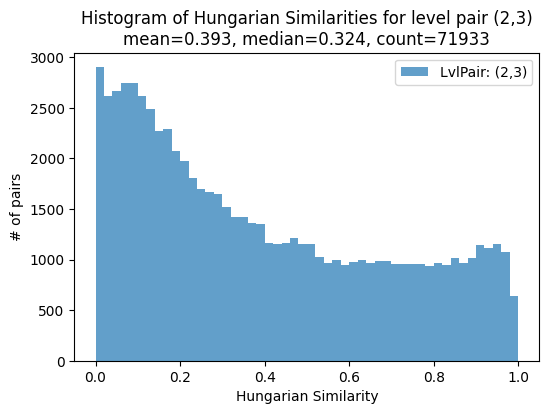

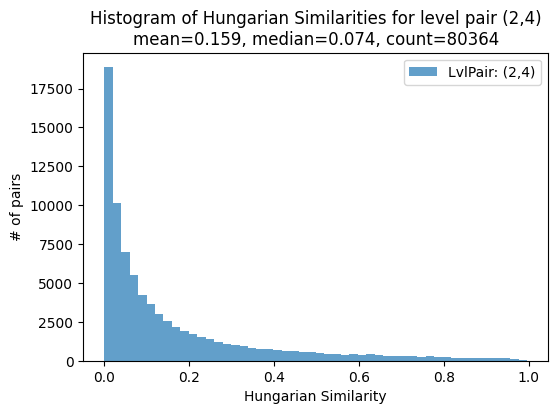

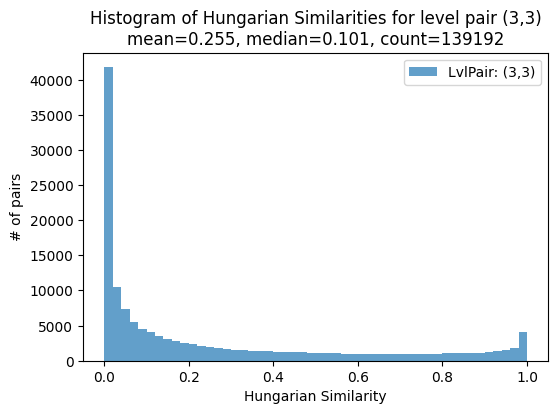

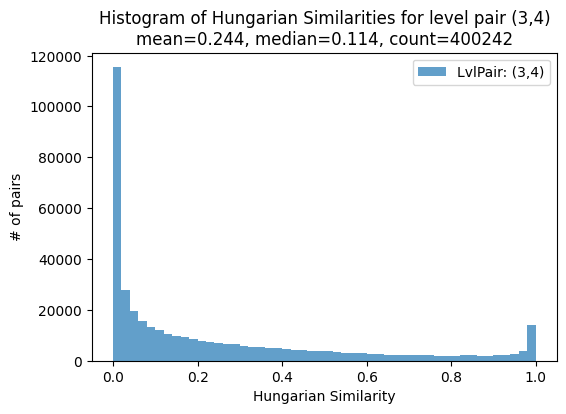

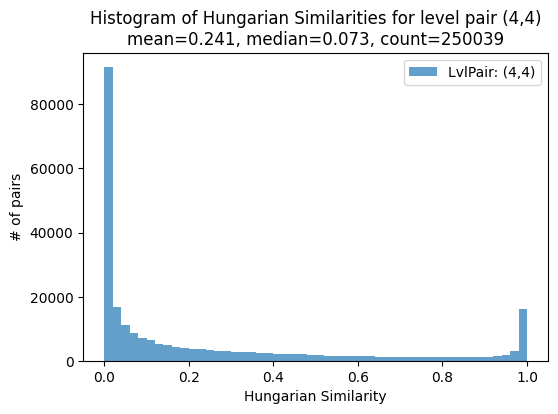

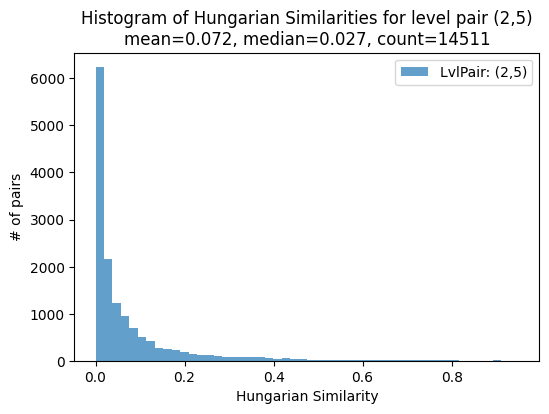

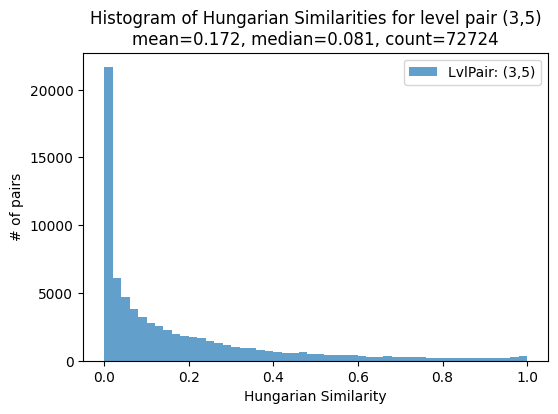

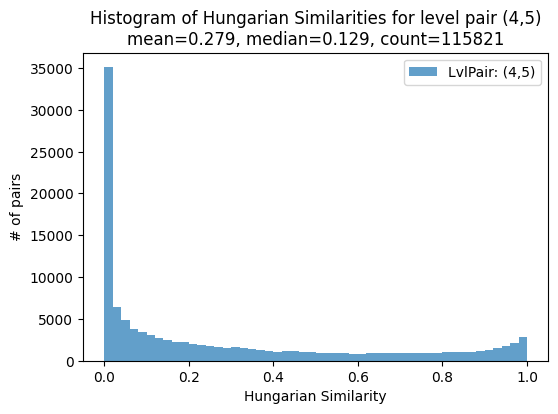

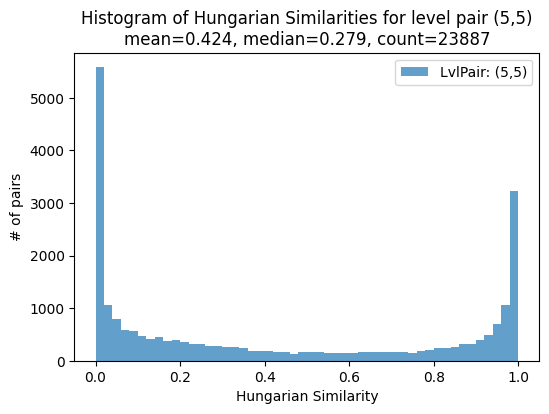

In [20]:
# Optionally plot each level pair in a separate figure:
plot_histograms_by_level_pairs(all_level_sims, mode="Hungarian")

In [25]:
# We want MS level 2 only
ms2_sims_hung = compute_same_level_similarity_limited(
    msn_dataset,
    target_level=2,
    use_embedding=False,
    sim_fn=hungarian_fn,
    tolerance=0.1,
    max_pairs=500  
)

stats_ms2_hung = summarize_similarity_distribution(ms2_sims_hung)
print("MS2<->MS2 (Hungarian) limited stats:", stats_ms2_hung)

MS2<->MS2 (Hungarian) limited stats: {'mean': 0.022353537793716256, 'std': 0.05934879960602478, 'median': 0.00456160157323064, 'count': 500}


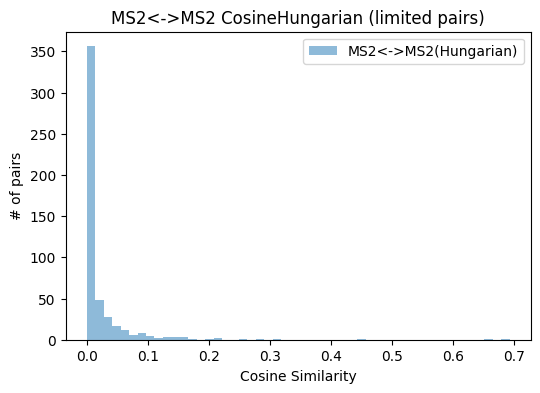

In [26]:
plot_histograms({
    "MS2<->MS2(Hungarian)": ms2_sims_hung
}, title="MS2<->MS2 CosineHungarian (limited pairs)", xlabel="Cosine Similarity")

## DreaMS embedding

In [27]:
embeddings_dict = load_embeddings(
    file_path="/Users/macbook/CODE/Majer:MassSpecGym/data/MSn/MSn_DreaMS.h5",
    identifier_col="identifiers",
    embedding_col="embeddings"
)

In [35]:
# 1) Ancestor-Descendant
embed_ad_sims = []
for tree in msn_dataset.trees:
    sims = compute_ancestor_descendant_similarity(
        tree,
        use_embedding=True,
        sim_fn=None,
        embeddings_dict=embeddings_dict
    )
    embed_ad_sims.extend(sims)
stats_ad = summarize_similarity_distribution(embed_ad_sims)

# 2) Siblings
embed_sib_sims = []
for tree in msn_dataset.trees:
    sims = compute_sibling_similarity(
        tree,
        use_embedding=True,
        sim_fn=None,
        embeddings_dict=embeddings_dict
    )
    embed_sib_sims.extend(sims)
stats_sib = summarize_similarity_distribution(embed_sib_sims)

# 3) Random pairs
embed_rand_sims = random_node_pairs(
    msn_dataset,
    num_pairs=5000,
    use_embedding=True,
    sim_fn=None,              
    embeddings_dict=embeddings_dict
)
stats_rand = summarize_similarity_distribution(embed_rand_sims)

In [36]:
print("Ancestor-Descendant (DreaMS) stats:", stats_ad)
print("Sibling (DreaMS) stats:", stats_sib)
print("Random pairs (DreaMS) stats:", stats_rand)

Ancestor-Descendant (DreaMS) stats: {'mean': 0.3994917571544647, 'std': 0.19029690325260162, 'median': 0.3847954273223877, 'count': 166808}
Sibling (DreaMS) stats: {'mean': 0.350467711687088, 'std': 0.2291901558637619, 'median': 0.3284909129142761, 'count': 173661}
Random pairs (DreaMS) stats: {'mean': 0.11952214688062668, 'std': 0.12343708425760269, 'median': 0.10753466188907623, 'count': 5000}


In [37]:
# TODO if one is signif better
stats_ad

{'mean': 0.3994917571544647,
 'std': 0.19029690325260162,
 'median': 0.3847954273223877,
 'count': 166808}

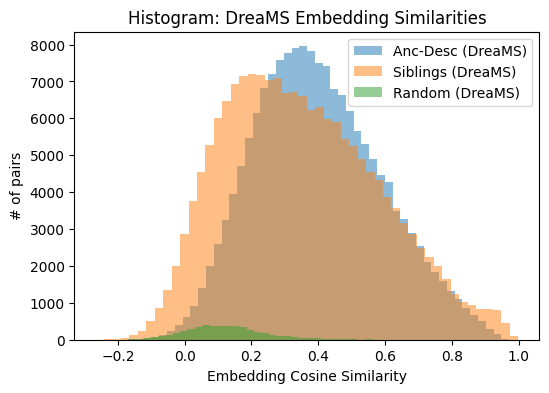

In [30]:
plot_histograms({
    "Anc-Desc (DreaMS)": embed_ad_sims,
    "Siblings (DreaMS)": embed_sib_sims,
    "Random (DreaMS)": embed_rand_sims
},
title="Histogram: DreaMS Embedding Similarities",
xlabel="Embedding Cosine Similarity")


In [31]:
# MS-Level Pair Analysis (embedding-based)
all_level_sims = {}
for tree in msn_dataset.trees:
    level_sims_dict = compute_pairwise_similarity_by_mslevel(
        tree,
        use_embedding=True,
        sim_fn=None,
        embeddings_dict=embeddings_dict
    )
    for (lvlA, lvlB), simvals in level_sims_dict.items():
        if (lvlA, lvlB) not in all_level_sims:
            all_level_sims[(lvlA, lvlB)] = []
        all_level_sims[(lvlA, lvlB)].extend(simvals)

# Print average for each level pair
for level_pair, vals in all_level_sims.items():
    stats_lv = summarize_similarity_distribution(vals)
    print(f"Level pair {level_pair} -> {stats_lv}")

Level pair (2, 3) -> {'mean': 0.36960604786872864, 'std': 0.18211105465888977, 'median': 0.35392341017723083, 'count': 71933}
Level pair (2, 4) -> {'mean': 0.21595095098018646, 'std': 0.13768118619918823, 'median': 0.20510858297348022, 'count': 80364}
Level pair (3, 3) -> {'mean': 0.3400874137878418, 'std': 0.23485657572746277, 'median': 0.3094925582408905, 'count': 139192}
Level pair (3, 4) -> {'mean': 0.3061775863170624, 'std': 0.22588127851486206, 'median': 0.26777011156082153, 'count': 400242}
Level pair (4, 4) -> {'mean': 0.34772124886512756, 'std': 0.25415658950805664, 'median': 0.2987461984157562, 'count': 250039}
Level pair (2, 5) -> {'mean': 0.21092155575752258, 'std': 0.12815092504024506, 'median': 0.20595784485340118, 'count': 14511}
Level pair (3, 5) -> {'mean': 0.3043021857738495, 'std': 0.1910751909017563, 'median': 0.2875922918319702, 'count': 72724}
Level pair (4, 5) -> {'mean': 0.40176916122436523, 'std': 0.23634786903858185, 'median': 0.3825491964817047, 'count': 1158

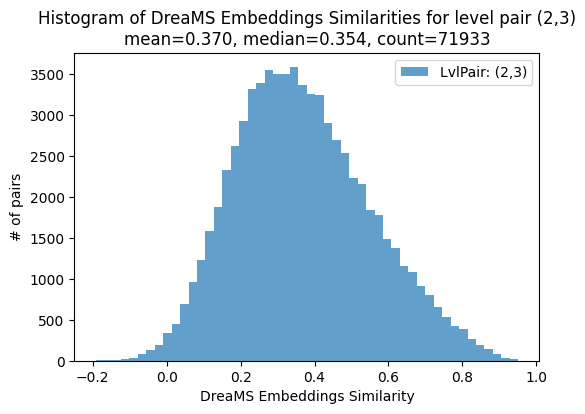

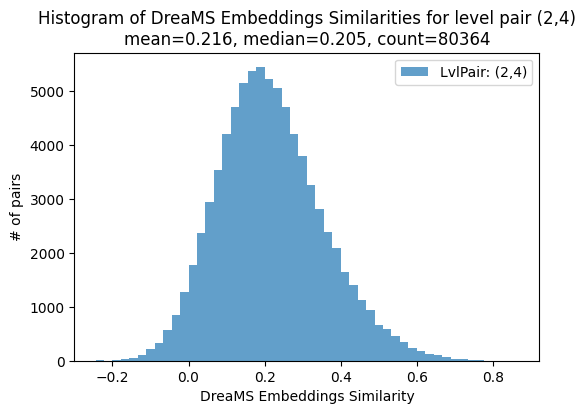

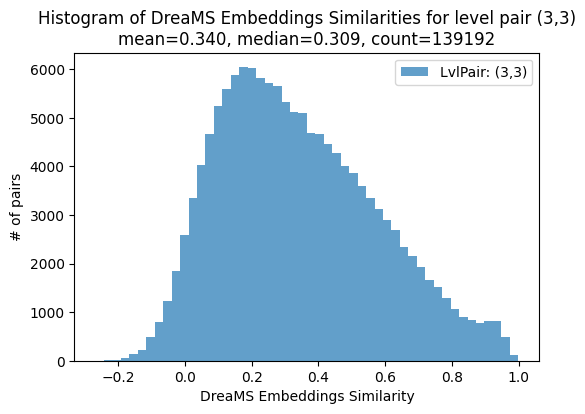

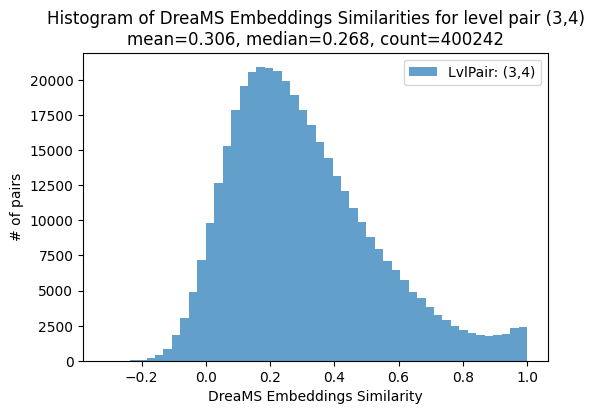

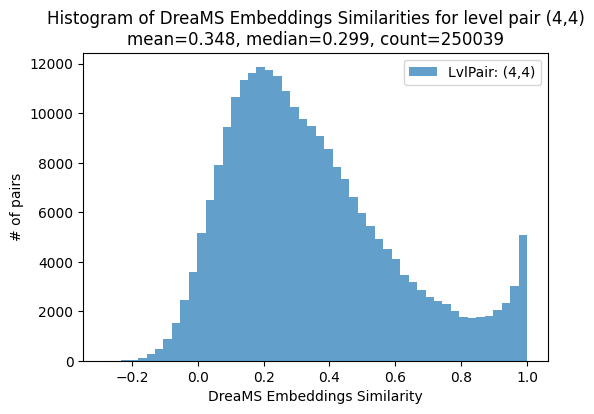

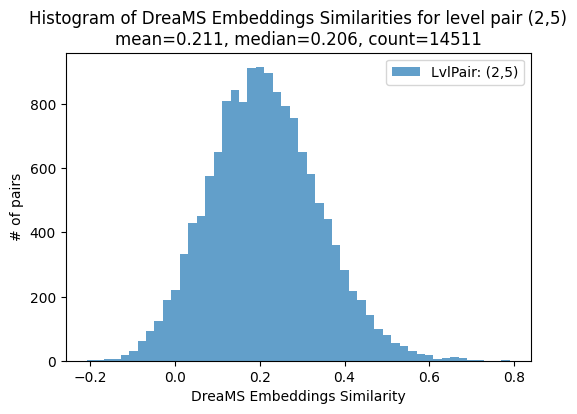

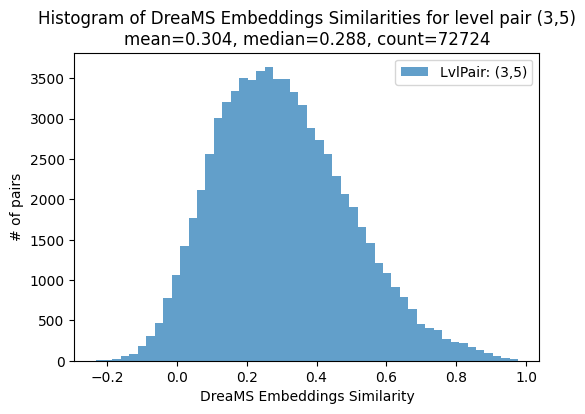

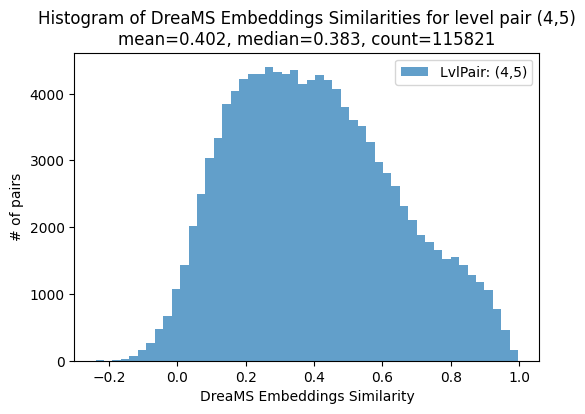

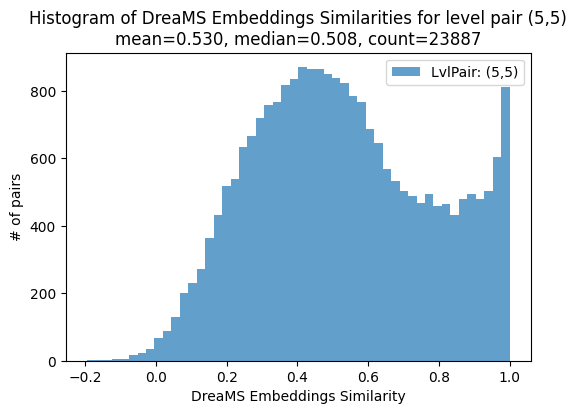

In [32]:
# Plot each level pair in a separate figure
plot_histograms_by_level_pairs(all_level_sims, mode="DreaMS Embeddings")

In [33]:
# MS2 <-> MS2 (embedding-based) with limited pairs
ms2_sims_emb = compute_same_level_similarity_limited(
    msn_dataset,
    target_level=2,
    use_embedding=True,
    sim_fn=None,  # => dreams_embedding_similarity
    embeddings_dict=embeddings_dict,
    max_pairs=5000   
)
stats_ms2_emb = summarize_similarity_distribution(ms2_sims_emb)
print("MS2<->MS2 (DreaMS embeddings) limited stats:", stats_ms2_emb)

MS2<->MS2 (DreaMS embeddings) limited stats: {'mean': 0.12317246198654175, 'std': 0.12449826300144196, 'median': 0.11809742450714111, 'count': 5000}


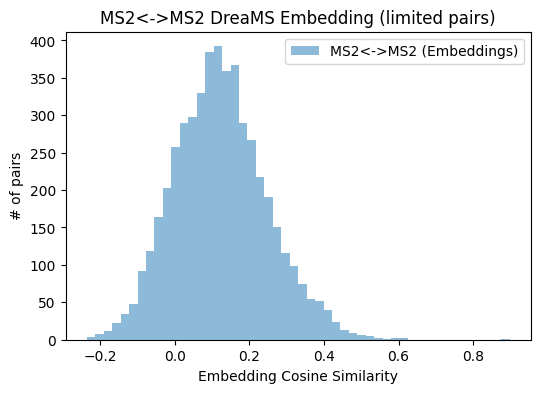

In [34]:
plot_histograms({
    "MS2<->MS2 (Embeddings)": ms2_sims_emb
}, title="MS2<->MS2 DreaMS Embedding (limited pairs)", xlabel="Embedding Cosine Similarity")